# Descarregar base de dados

In [6]:
#import soundata

#dataset = soundata.initialize('urbansound8k')
#dataset.download()  # download the dataset
#dataset.validate()  # validate that all the expected files are there

#example_clip = dataset.choice_clip()  # choose a random example clip
#print(example_clip)  # see the available data

In [7]:
#import IPython.display as ipd
#ipd.Audio('C:\\tmp\\sound_datasets\\urbansound8k\\audio\\fold9\\54976-4-0-4.wav')

# Metadata

In [1]:
import pandas as pd
us=pd.read_csv("C:\\Users\\tiago\\AC2\\sound_datasets\\urbansound8k\\metadata\\UrbanSound8k.csv")
us.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


This file contains meta-data information about every audio file in the dataset. This includes:

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID:
A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.

In [9]:
us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


C:\Users\tiago\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='class', ylabel='count'>

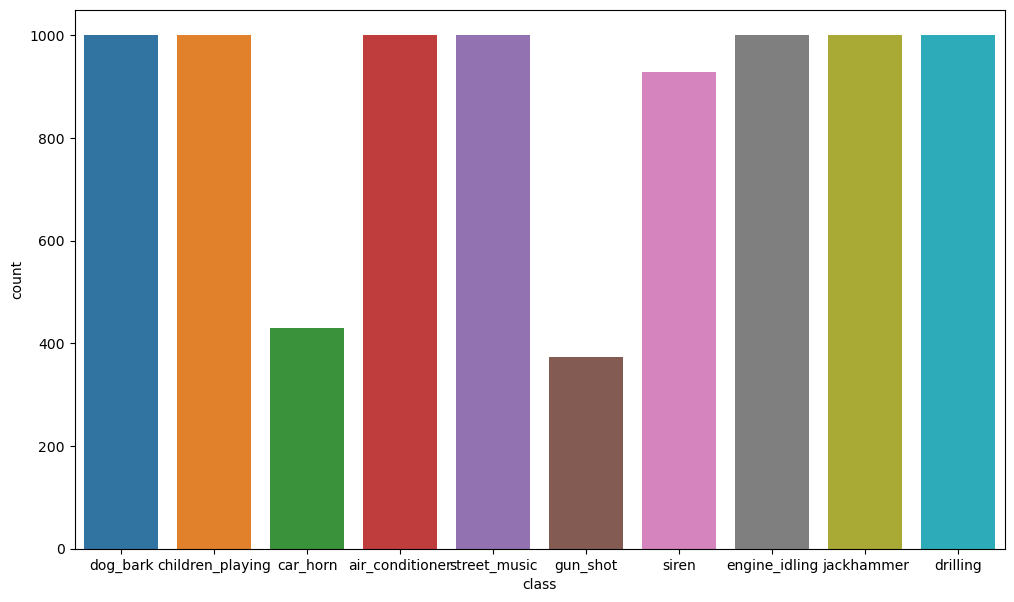

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
sns.countplot(us['class'])

Conseguimos observar que ha um desbalanceamento de classes o que fara com que tinhamos de fazer alteraçoes nos modelos de forma a que as classes minoritarias tenham o mesmo impacto das restantes.

# Base Line

Como base line iremos apenas usar o folder 1, fazendo um resample de todos os audios e um zero padding para que todos tenham a mesma duraçao (4 segundos).

In [11]:
import librosa
import numpy as np

In [12]:
_wav_dir_='C:\\Users\\tiago\\AC2\\sound_datasets\\urbansound8k\\audio\\fold1'
files = librosa.util.find_files(_wav_dir_)

C:\Users\tiago\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [13]:
# resampling freq
target_sr =44100

# MFCC parameters
n_mfcc=15
hop_length=round(target_sr*0.0125) #tamanho do salto entre as janelas de análise em amostras (1,25% do sr)
win_length=round(target_sr*0.023) # tamanho da janela de análise em amostras (2,3% do sr)
n_fft=2**14
mfcc_time_size = 4*target_sr//hop_length+1

# read all wav file without resampling
dataset=np.zeros(shape=[len(files),4*target_sr])
dataset_mfcc=np.zeros(shape=[len(files),n_mfcc,mfcc_time_size])

In [14]:
i=0
for f in files:
    (sig, rate) = librosa.load(f, sr=None)
    sig_res =librosa.resample(sig, orig_sr=rate, target_sr=target_sr)
    # zero padding
    if len(sig_res)<4*target_sr:
        sig_res_pad = np.concatenate((sig_res, np.zeros(4*target_sr-len(sig_res))),axis=0)
    else:
        sig_res_pad=sig_res
    dataset[i]=sig_res_pad
    # computes the MFCCs
    sig_mfcc =librosa.feature.mfcc(y=sig_res_pad,sr=target_sr,n_fft=n_fft,hop_length=hop_length,win_length=win_length,n_mfcc=n_mfcc)
    dataset_mfcc[i]=sig_mfcc
    i+=1

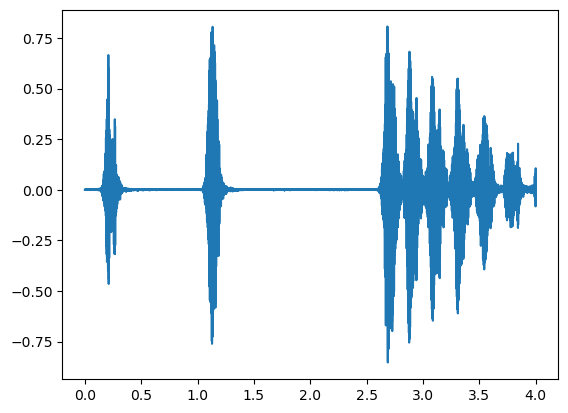

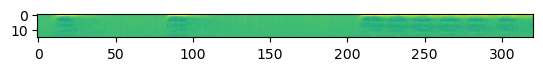

In [15]:
index=0
plt.figure()
plt.plot(np.asarray(list(range(4*target_sr)))/target_sr,dataset[index])
plt.show()

plt.figure()
plt.imshow(dataset_mfcc[index])
plt.show()

Iremos usar estes dados de 2 dimensoes apenas para os modelos CNN, para as MLP iremos retirar as medias para cada coeficiente.

In [16]:
import librosa
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import os

# Lista para armazenar as características extraídas
features = []
Y = []  # Lista para armazenar informações sobre os áudios (nome e classe)

i = 0
for f in files:
    #print(f)
    (sig, rate) = librosa.load(f, sr=None)
    sig_res = librosa.resample(sig, orig_sr=rate, target_sr=target_sr)

    # zero padding
    if len(sig_res) < 4 * target_sr:
        sig_res_pad = np.concatenate((sig_res, np.zeros(4 * target_sr - len(sig_res))), axis=0)
    else:
        sig_res_pad = sig_res

    dataset[i] = sig_res_pad

    # computes the MFCCs
    sig_mfcc = librosa.feature.mfcc(y=sig_res_pad, sr=target_sr, n_fft=n_fft, hop_length=hop_length,
                                    win_length=win_length, n_mfcc=n_mfcc)

    # Calcula as estatísticas resumidas para cada coeficiente MFCC ao longo do tempo
    summary_stats = np.concatenate([
        np.mean(sig_mfcc, axis=1),
    ])

    features.append(summary_stats)

    # Obtém a classe do áudio com base no arquivo de dados
    audio_name = f.split('/')[-1]  # obtém o nome do arquivo
    audio_name = os.path.basename(audio_name)
    #print(audio_name)
    audio_class = us.loc[us['slice_file_name'] == audio_name, 'class'].values[0]

    Y.append({'name': audio_name, 'class': audio_class})

    i += 1

# Converte a lista de características em uma matriz numpy
feature_matrix = np.array(features)
Y_df = pd.DataFrame(Y)  # Converte a lista Y em um DataFrame do pandas para facilitar a manipulação


In [17]:
Y_df.head()

,name,class
0,101415-3-0-2.wav,dog_bark
1,101415-3-0-3.wav,dog_bark
2,101415-3-0-8.wav,dog_bark
3,102106-3-0-0.wav,dog_bark
4,102305-6-0-0.wav,gun_shot


In [18]:
features

[array([-363.6253   ,   89.42283  ,   30.723892 ,    4.6886697,
         -12.045379 ,    2.0376308,    1.4272647,   -7.954745 ,
          -9.304504 ,   -4.423736 ,   -7.0504856,   -3.795605 ,
           2.0155342,   -3.9454238,    0.507045 ], dtype=float32),
 array([-3.3253455e+02,  1.1846223e+02,  4.5798111e+01,  6.1927867e+00,
        -2.1299673e+01, -8.7260121e-01, -5.1512197e-02, -1.5354960e+01,
        -1.7989960e+01, -1.3265500e+01, -1.5188495e+01, -6.1702862e+00,
         2.4266140e+00, -4.7309546e+00,  2.7130485e+00], dtype=float32),
 array([-3.7757999e+02,  6.8861725e+01,  1.8146807e+01,  6.7936716e+00,
        -1.3116068e+00,  6.5913110e+00,  2.1109946e+00, -3.7674453e+00,
        -3.5477431e+00, -4.3293017e-01, -1.4881681e+00,  3.0273795e-01,
         4.8350558e+00,  1.3961033e+00,  4.6832129e-01], dtype=float32),
 array([-479.49308101,   59.84773364,  -17.62688493,    0.82897774,
         -12.06373992,    6.7055871 ,  -10.93479041,    6.9751355 ,
          -4.69204828,    3

# A classifier based on a multilayer perceptron (MLP)




Epoch 1/15


22/22 [==============================] - 1s 8ms/step - loss: 26.2367 - accuracy: 0.1103 - val_loss: 12.6773 - val_accuracy: 0.1839
Epoch 2/15
22/22 [==============================] - 0s 2ms/step - loss: 9.6582 - accuracy: 0.2106 - val_loss: 5.1386 - val_accuracy: 0.2529
Epoch 3/15
22/22 [==============================] - 0s 2ms/step - loss: 4.2633 - accuracy: 0.3295 - val_loss: 3.2152 - val_accuracy: 0.3908
Epoch 4/15
22/22 [==============================] - 0s 2ms/step - loss: 3.0074 - accuracy: 0.4943 - val_loss: 2.5582 - val_accuracy: 0.4483
Epoch 5/15
22/22 [==============================] - 0s 2ms/step - loss: 2.3428 - accuracy: 0.5487 - val_loss: 1.9798 - val_accuracy: 0.5172
Epoch 6/15
22/22 [==============================] - 0s 2ms/step - loss: 1.8552 - accuracy: 0.5974 - val_loss: 1.6469 - val_accuracy: 0.5632
Epoch 7/15
22/22 [==============================] - 0s 2ms/step - loss: 1.5638 - accuracy: 0.6232 - val_loss: 1.4779 - val_accuracy: 0.5172
Epoch 8/15
22

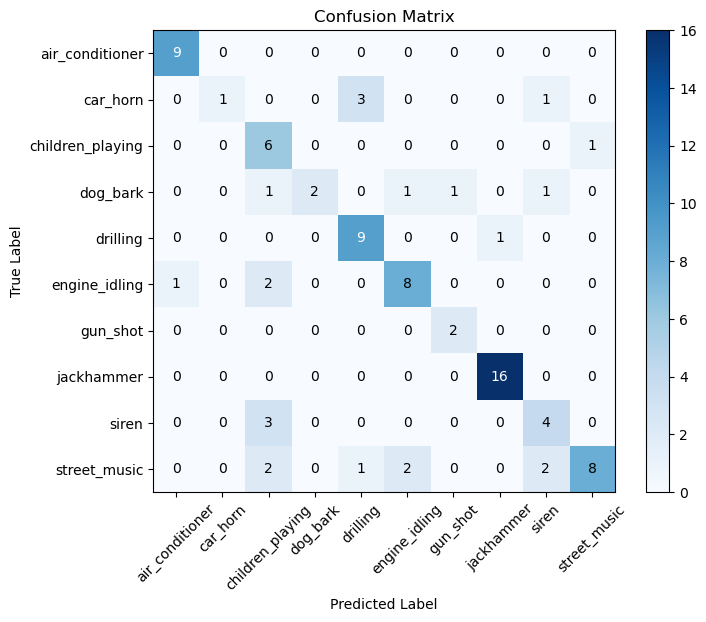

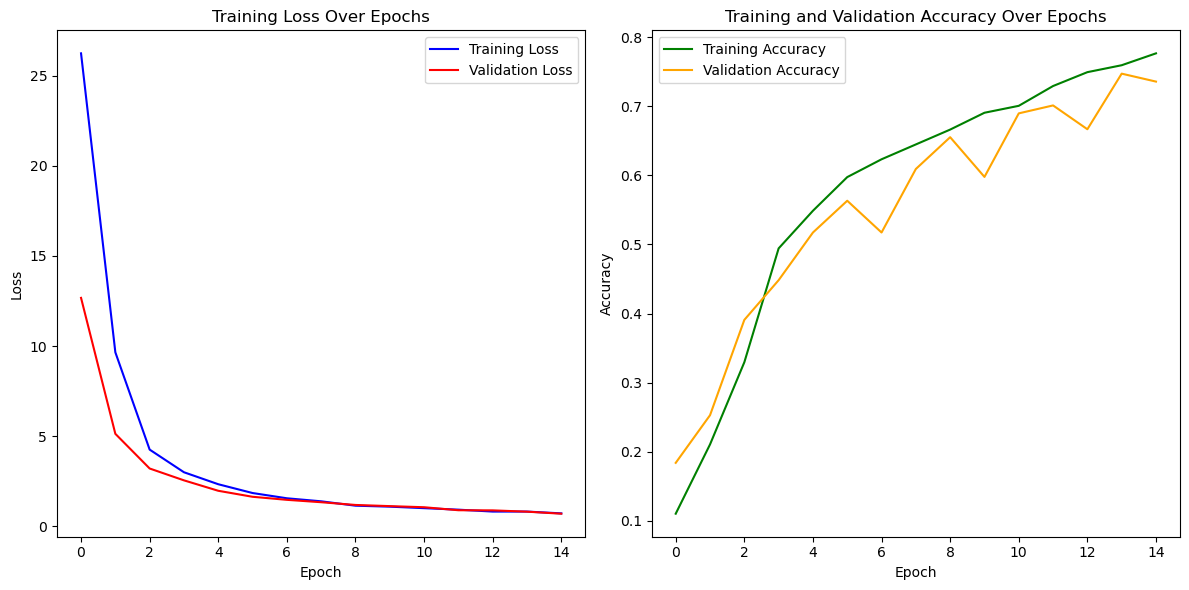

In [19]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Convert the class labels to numerical values
label_encoder = LabelEncoder()
Y_df['class_encoded'] = label_encoder.fit_transform(Y_df['class'])

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(feature_matrix, Y_df['class_encoded'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build and train the TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and get training history
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=15
)

# Evaluate the model on the test set
_, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Plot confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Display values in each element
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training history - Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



# A classifier based on a convolutional neural network (CNN)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 319, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 159, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 157, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 78, 32)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4992)              0         
                                                                 
 dense_2 (Dense)             (None, 64)              

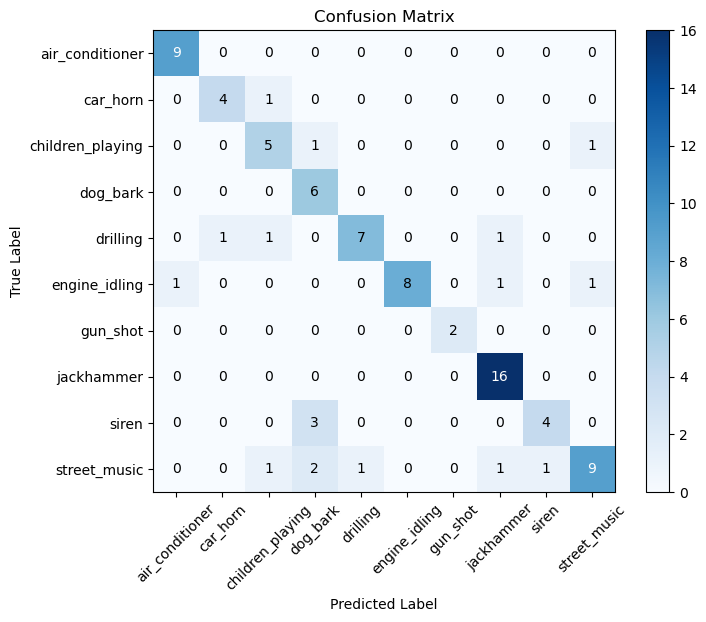

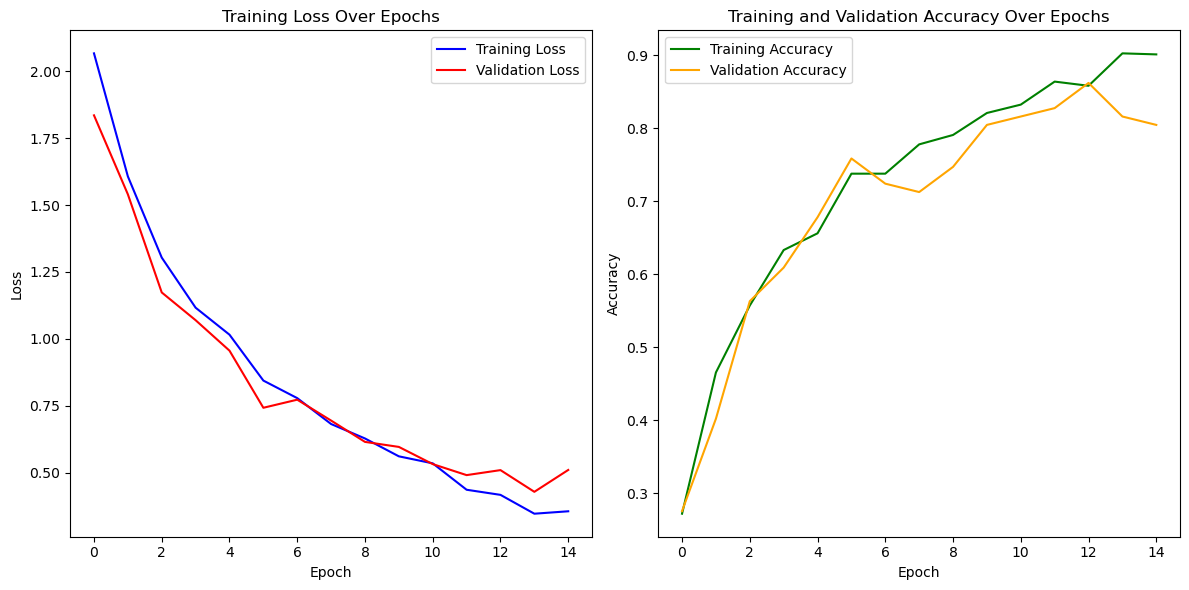

In [20]:
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical

# Convert the class labels to numerical values
label_encoder = LabelEncoder()
Y_df['class_encoded'] = label_encoder.fit_transform(Y_df['class'])

num_classes = len(Y_df['class'].unique())

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(dataset_mfcc, Y_df['class_encoded'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data
v = dataset_mfcc.max()
X_train_scaled = X_train / v
X_val_scaled = X_val / v
X_test_scaled = X_test / v

# Convert the class labels to one-hot encoding
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(n_mfcc, mfcc_time_size, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_scaled,
    y_train_encoded,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_encoded)
)

# Evaluate the model on the test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {accuracy}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Display values in each element
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training history - Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Project

Numa primeira fase do trabalho iremos arranjar alterantivas para o preenchimento do som de forma a que todos os audios tenham a mesma duração.

1- Repetição do som: repetir o som ate fazer os segundos target.

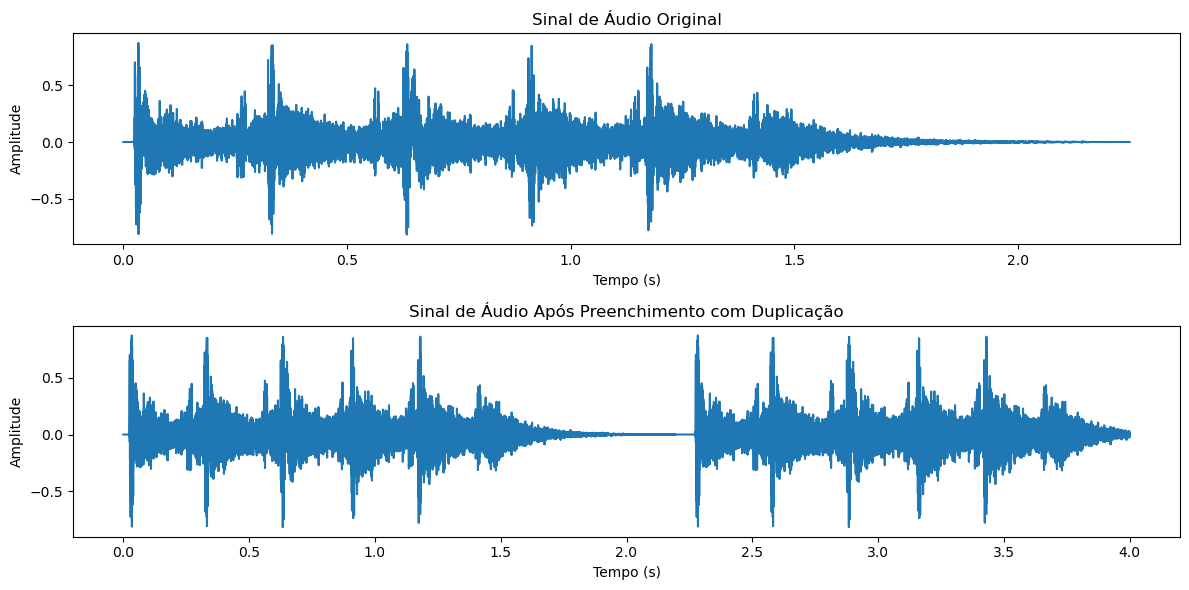

In [21]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Defina as variáveis necessárias
target_sr = 44100  # Sua taxa de amostragem desejada
n_fft = 2048  # Seus parâmetros desejados
hop_length = 512
win_length = 1024
n_mfcc = 13

# Nome do arquivo desejado
desired_file = "C:\\Users\\tiago\\AC2\\sound_datasets\\urbansound8k\\audio\\fold1\\7061-6-0-0.wav"

# Carregue o áudio original
(sig, rate) = librosa.load(desired_file, sr=None)

# Resample audio
sig_resampled = librosa.resample(sig, orig_sr=rate, target_sr=target_sr)

# Preenchimento com duplicação
num_repeats = int(np.ceil(4 * target_sr / len(sig_resampled)))
sig_filled = np.tile(sig_resampled, num_repeats)[:4 * target_sr]

# Crie o vetor de tempo para a versão preenchida
time_filled = np.linspace(0, 4, len(sig_filled))

# Plotar o sinal original em relação ao tempo
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title('Sinal de Áudio Original')
plt.plot(np.linspace(0, len(sig) / rate, len(sig)), sig)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')

# Plotar o sinal após o preenchimento com duplicação em relação ao tempo
plt.subplot(2, 1, 2)
plt.title('Sinal de Áudio Após Preenchimento com Duplicação')
plt.plot(time_filled, sig_filled)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

2-Interpolação: A interpolação no contexto de processamento de sinais de áudio refere-se ao processo de aumentar ou diminuir a taxa de amostragem de um sinal.

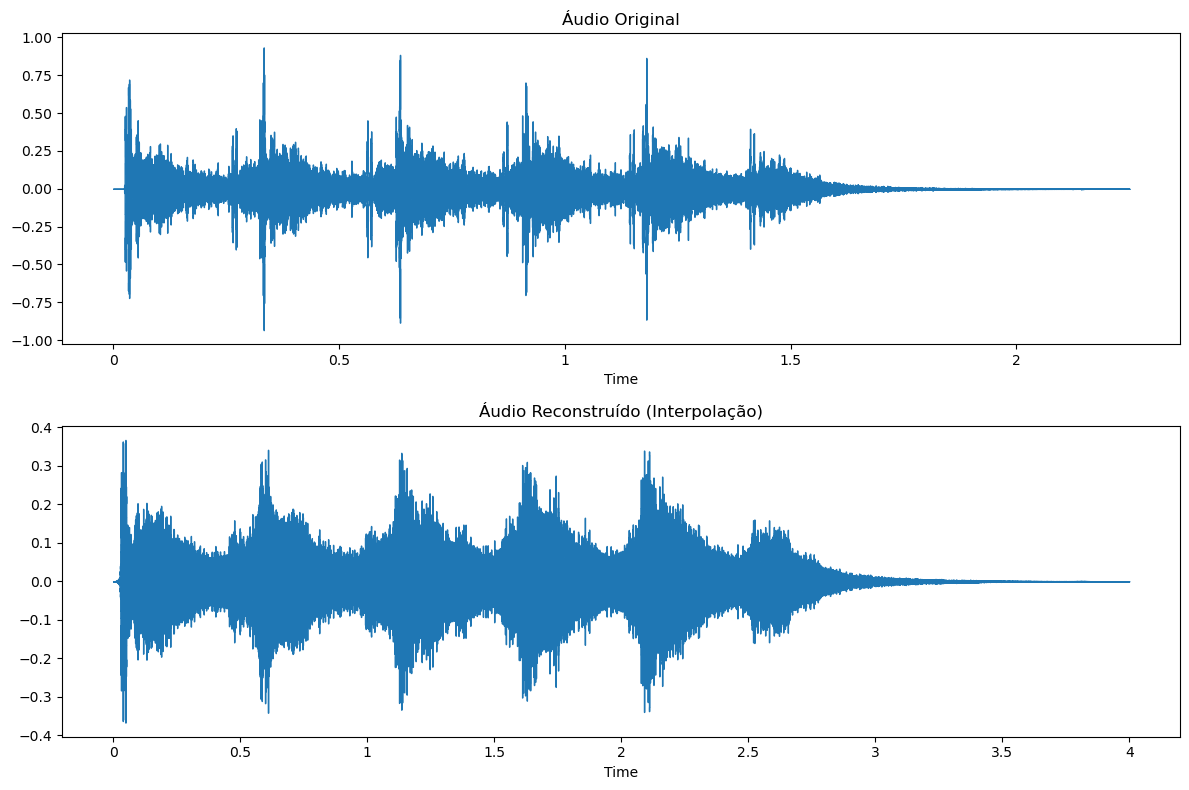

In [22]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Carregue o áudio original
audio_file = "C:\\Users\\tiago\\AC2\\sound_datasets\\urbansound8k\\audio\\fold1\\7061-6-0-0.wav"
y, sr = librosa.load(audio_file, sr=None)

# Aplique a preênfase
y_preemphasized = librosa.effects.preemphasis(y)

# Defina a duração desejada em segundos
duration_target = 4

# Calcule o fator de velocidade para o time_stretch
speed_factor = len(y_preemphasized) / (duration_target * sr)

# Interpole o sinal usando time_stretch
y_interpolated = librosa.effects.time_stretch(y_preemphasized, rate=speed_factor)

# Plotar o áudio original e o áudio reconstruído
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y_preemphasized, sr=sr)
plt.title('Áudio Original')

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_interpolated, sr=sr)
plt.title('Áudio Reconstruído (Interpolação)')

plt.tight_layout()
plt.show()

Para o modelo MLP iremos testar quer a repetiçao quer a interpolação. Para alem disso iremos adicionar mais algumas estatisticas para alem da media.

In [23]:
import numpy as np
import librosa
import os
import pandas as pd
from scipy.stats import skew, kurtosis

# Defining parameters
target_sr = 44100
n_mfcc = 15
hop_length = round(target_sr * 0.0125)
win_length = round(target_sr * 0.023)
n_fft = 2**14
mfcc_time_size = 4 * target_sr // hop_length + 1

# Directory containing audio files
audio_directory = "C:\\Users\\tiago\\AC2\\sound_datasets\\urbansound8k\\audio\\fold1"

# List to store data
dataset_mfcc_repetiçao_mlp = []
Y = []

for f in files:
    # Complete path to the audio file
    audio_path = os.path.join(audio_directory, f)

    # Load original audio
    (sig, rate) = librosa.load(audio_path, sr=None)

    # Resample audio
    sig_resampled = librosa.resample(sig, orig_sr=rate, target_sr=target_sr)

    # If the duration is less than 4 seconds, apply repetition
    if len(sig_resampled) < 4 * target_sr:
        # Repeat audio
        num_repeats = int(np.ceil(4 * target_sr / len(sig_resampled)))
        sig_filled = np.tile(sig_resampled, num_repeats)[:4 * target_sr]

        # Create time vector for the filled version
        time_filled = np.linspace(0, 4, len(sig_filled))

        # Calculate MFCCs
        sig_mfcc = librosa.feature.mfcc(y=sig_filled, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)

        # Calculate statistics for each MFCC coefficient
        mfcc_stats = np.concatenate([
            np.mean(sig_mfcc, axis=1),
            np.std(sig_mfcc, axis=1),
            skew(sig_mfcc, axis=1),
            kurtosis(sig_mfcc, axis=1),
            np.min(sig_mfcc, axis=1),
            np.max(sig_mfcc, axis=1),
        ])
    else:
        # Calculate MFCCs directly
        sig_mfcc = librosa.feature.mfcc(y=sig_resampled, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)

        # Calculate statistics for each MFCC coefficient
        mfcc_stats = np.concatenate([
            np.mean(sig_mfcc, axis=1),
            np.std(sig_mfcc, axis=1),
            skew(sig_mfcc, axis=1),
            kurtosis(sig_mfcc, axis=1),
            np.min(sig_mfcc, axis=1),
            np.max(sig_mfcc, axis=1),
        ])

    # Add to the dataset
    dataset_mfcc_repetiçao_mlp.append(mfcc_stats)

    # Get the audio class based on the data file
    audio_name = f.split('/')[-1]  # get the file name
    audio_name = os.path.basename(audio_name)
    audio_class = us.loc[us['slice_file_name'] == audio_name, 'class'].values[0]

    Y.append({'name': audio_name, 'class': audio_class})

# Now, dataset_mfcc_interpolaçao contains the MFCCs for each audio after resampling and repetition if necessary
Y_df_repetiçao_mlp = pd.DataFrame(Y)  # Convert the list Y to a pandas DataFrame for easier manipulation

Epoch 1/15
21/21 [==============================] - 0s 6ms/step - loss: 2.3750 - accuracy: 0.2125 - val_loss: 1.9357 - val_accuracy: 0.3303
Epoch 2/15
21/21 [==============================] - 0s 2ms/step - loss: 1.6812 - accuracy: 0.4587 - val_loss: 1.4747 - val_accuracy: 0.5596
Epoch 3/15
21/21 [==============================] - 0s 2ms/step - loss: 1.3210 - accuracy: 0.6284 - val_loss: 1.2380 - val_accuracy: 0.6697
Epoch 4/15
21/21 [==============================] - 0s 2ms/step - loss: 1.0933 - accuracy: 0.7034 - val_loss: 1.0616 - val_accuracy: 0.7431
Epoch 5/15
21/21 [==============================] - 0s 2ms/step - loss: 0.9319 - accuracy: 0.7599 - val_loss: 0.9345 - val_accuracy: 0.7706
Epoch 6/15
21/21 [==============================] - 0s 2ms/step - loss: 0.8010 - accuracy: 0.7905 - val_loss: 0.8260 - val_accuracy: 0.7982
Epoch 7/15
21/21 [==============================] - 0s 2ms/step - loss: 0.6965 - accuracy: 0.8150 - val_loss: 0.7417 - val_accuracy: 0.8165
Epoch 8/15
21/21 [==

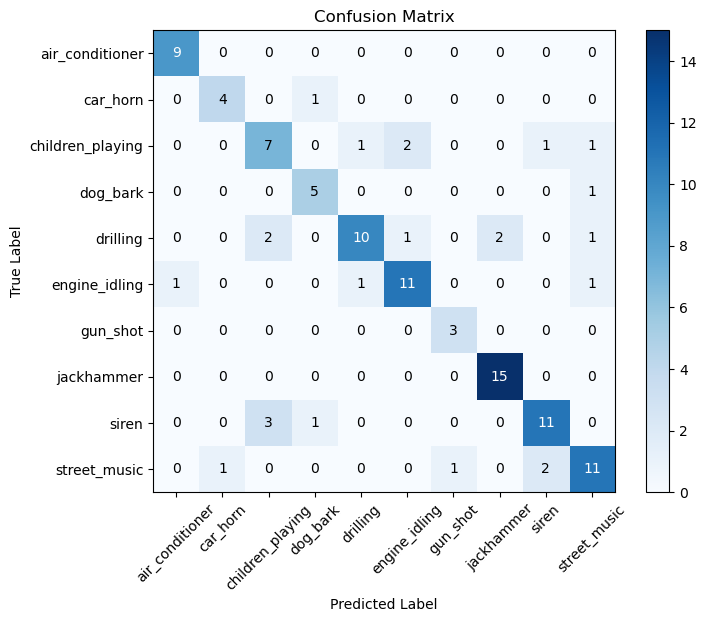

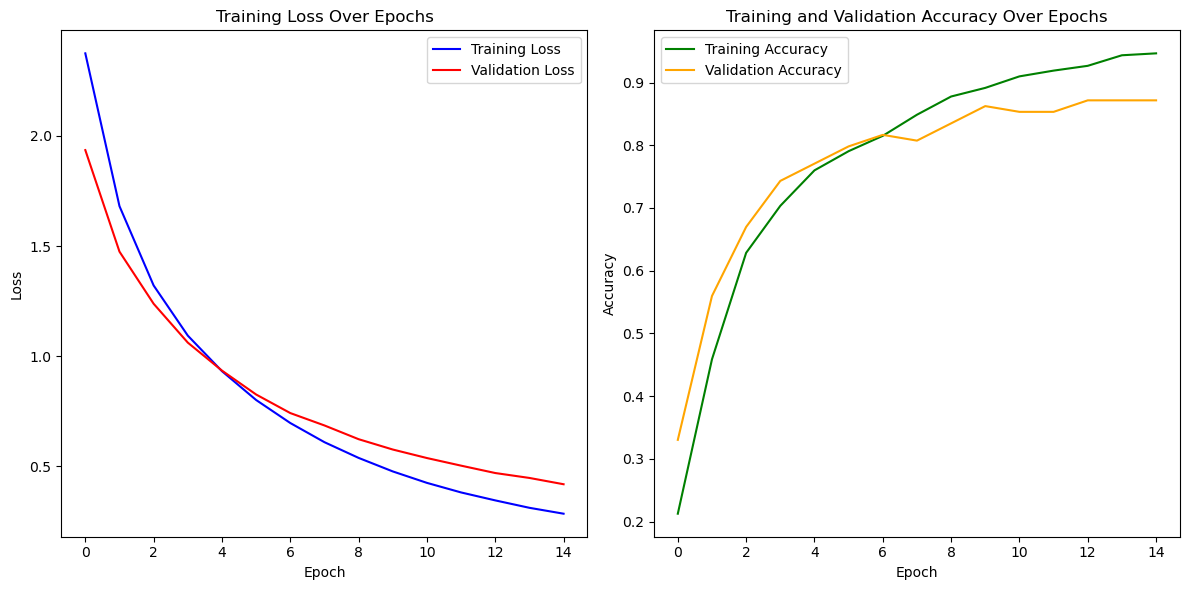

In [29]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Convert the class labels to numerical values
label_encoder = LabelEncoder()
Y_df_repetiçao_mlp['class_encoded'] = label_encoder.fit_transform(Y_df['class'])
dataset_mfcc_repetiçao_mlp=np.array(dataset_mfcc_repetiçao_mlp)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(dataset_mfcc_repetiçao_mlp, Y_df_repetiçao_mlp['class_encoded'], test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

# Build and train the simplified TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and get training history
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=15)

# Evaluate the model
_, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")

# Plot confusion matrix
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Display values in each element
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training history - Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

com isto conseguimos perceber que as alteraçoes tiveram um efeito positivo. 

### MLP com interpolaçao e varias estatisticas

In [30]:
import numpy as np
import librosa
import os
import pandas as pd
from scipy.stats import skew, kurtosis

# Definindo parâmetros
target_sr = 44100
n_mfcc = 15
hop_length = round(target_sr * 0.0125)
win_length = round(target_sr * 0.023)
n_fft = 2**14
mfcc_time_size = 4 * target_sr // hop_length + 1

# Diretório contendo os arquivos de áudio
audio_directory = "C:\\Users\\tiago\\AC2\\sound_datasets\\urbansound8k\\audio\\fold1"

# Lista para armazenar os dados
dataset_mfcc_interpolaçao_mlp = []
Y=[]

for f in files:
    # Caminho completo para o arquivo de áudio
    audio_path = os.path.join(audio_directory, f)

    # Carregar áudio original
    (sig, rate) = librosa.load(audio_path, sr=None)

    # Resample audio
    sig_resampled = librosa.resample(sig, orig_sr=rate, target_sr=target_sr)

    # Se a duração for inferior a 4 segundos, aplique interpolação
    if len(sig_resampled) < 4 * target_sr:
        y_preemphasized = librosa.effects.preemphasis(sig_resampled)
        duration_target = 4
        speed_factor = len(y_preemphasized) / (duration_target * target_sr)
        y_interpolated = librosa.effects.time_stretch(y_preemphasized, rate=speed_factor)

        # Calcula os MFCCs
        sig_mfcc = librosa.feature.mfcc(y=y_interpolated, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)

        # Calcula estatísticas para cada coeficiente MFCC
        mfcc_stats = np.concatenate([
            np.mean(sig_mfcc, axis=1),
            np.std(sig_mfcc, axis=1),
            skew(sig_mfcc, axis=1),
            kurtosis(sig_mfcc, axis=1),
            np.min(sig_mfcc, axis=1),
            np.max(sig_mfcc, axis=1),
        ])
    else:
        # Calcula os MFCCs diretamente
        sig_mfcc = librosa.feature.mfcc(y=sig_resampled, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)

        # Calcula estatísticas para cada coeficiente MFCC
        mfcc_stats = np.concatenate([
            np.mean(sig_mfcc, axis=1),
            np.std(sig_mfcc, axis=1),
            skew(sig_mfcc, axis=1),
            kurtosis(sig_mfcc, axis=1),
            np.min(sig_mfcc, axis=1),
            np.max(sig_mfcc, axis=1),
        ])

    # Adiciona ao conjunto de dados
    dataset_mfcc_interpolaçao_mlp.append(mfcc_stats)
    
    # Obtém a classe do áudio com base no arquivo de dados
    audio_name = f.split('/')[-1]  # obtém o nome do arquivo
    audio_name = os.path.basename(audio_name)
    audio_class = us.loc[us['slice_file_name'] == audio_name, 'class'].values[0]

    Y.append({'name': audio_name, 'class': audio_class})


# Agora, dataset_mfcc_interpolaçao contém os MFCCs para cada áudio após resampling e interpolação se necessário
Y_df_interpolaçao_mlp = pd.DataFrame(Y)  # Converte a lista Y em um DataFrame do pandas para facilitar a manipulação

Epoch 1/15
22/22 [==============================] - 0s 7ms/step - loss: 2.6164 - accuracy: 0.1347 - val_loss: 1.9087 - val_accuracy: 0.3218
Epoch 2/15
22/22 [==============================] - 0s 2ms/step - loss: 1.7168 - accuracy: 0.4083 - val_loss: 1.4488 - val_accuracy: 0.5402
Epoch 3/15
22/22 [==============================] - 0s 2ms/step - loss: 1.3128 - accuracy: 0.5788 - val_loss: 1.1964 - val_accuracy: 0.6092
Epoch 4/15
22/22 [==============================] - 0s 2ms/step - loss: 1.0744 - accuracy: 0.6777 - val_loss: 1.0334 - val_accuracy: 0.6667
Epoch 5/15
22/22 [==============================] - 0s 2ms/step - loss: 0.9061 - accuracy: 0.7335 - val_loss: 0.8896 - val_accuracy: 0.7356
Epoch 6/15
22/22 [==============================] - 0s 2ms/step - loss: 0.7757 - accuracy: 0.7880 - val_loss: 0.7981 - val_accuracy: 0.7586
Epoch 7/15
22/22 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.8223 - val_loss: 0.7191 - val_accuracy: 0.7701
Epoch 8/15
22/22 [==

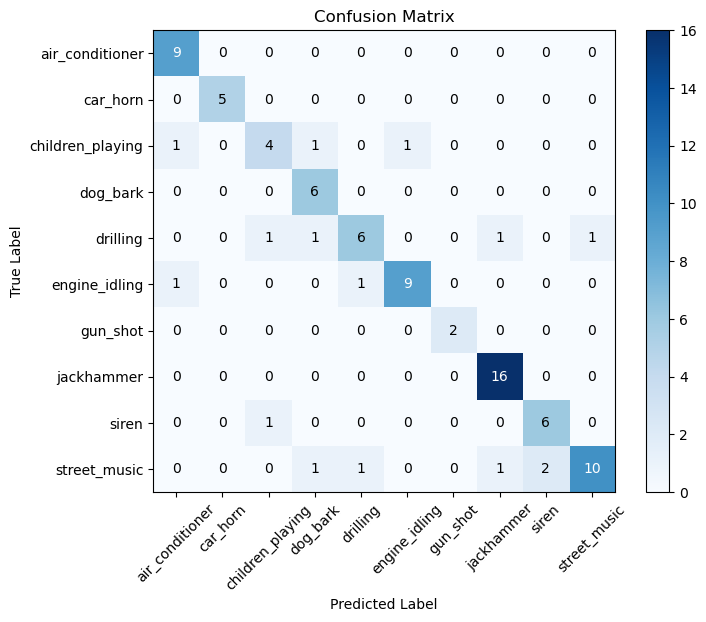

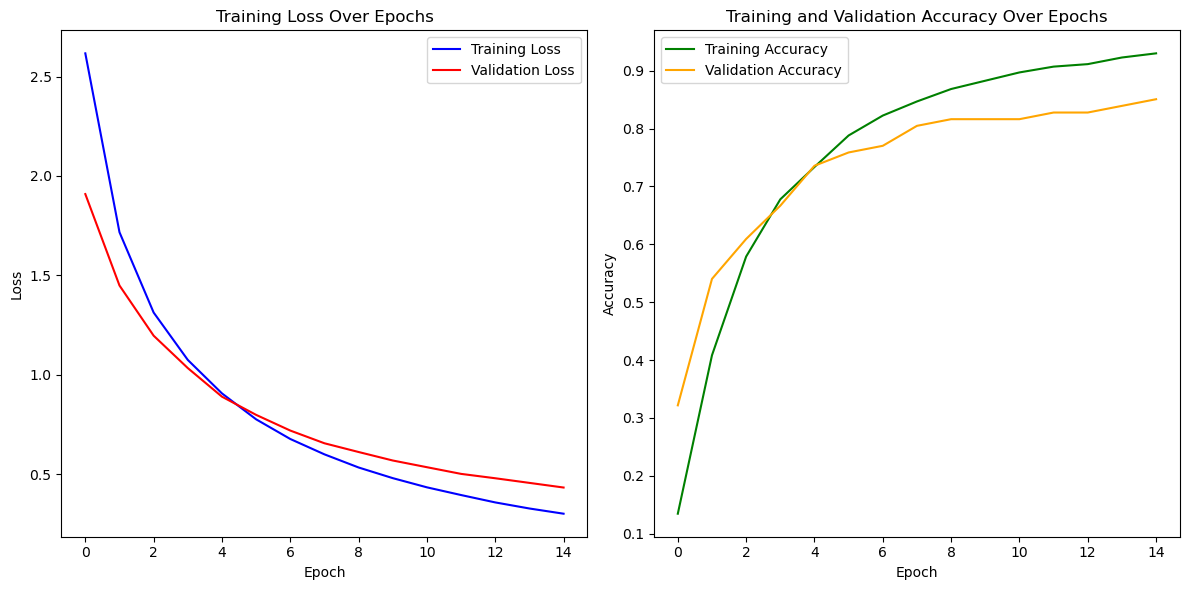

In [93]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Convert the class labels to numerical values
label_encoder = LabelEncoder()
Y_df_interpolaçao_mlp['class_encoded'] = label_encoder.fit_transform(Y_df_interpolaçao_mlp['class'])
dataset_mfcc_interpolaçao_mlp=np.array(dataset_mfcc_interpolaçao_mlp)


# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(dataset_mfcc_interpolaçao_mlp,Y_df_interpolaçao_mlp['class_encoded'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

# Build and train the simplified TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and get training history
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=15)

# Evaluate the model
_, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")

# Plot confusion matrix
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Display values in each element
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training history - Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Ao aplicar as duas tecnicas percebmos que a interpolação teve uma melhor perfomance para este modelo. Sendo assim, iremos apenas utilizar essa no decorrer do projeto.

### CNN com repetiçao 

In [32]:
import numpy as np
import librosa
import os
import pandas as pd
import matplotlib.pyplot as plt

# Defining parameters
target_sr = 44100
n_mfcc = 15
hop_length = round(target_sr * 0.0125)
win_length = round(target_sr * 0.023)
n_fft = 2**14
mfcc_time_size = 4 * target_sr // hop_length + 1

# Directory containing the audio files
audio_directory = "C:\\Users\\tiago\\AC2\\sound_datasets\\urbansound8k\\audio\\fold1"

# List to store the data
dataset_mfcc_repetiçao_cnn = []
Y = []

for f in files:
    # Complete audio path
    audio_path = os.path.join(audio_directory, f)

    # Load original audio
    (sig, rate) = librosa.load(audio_path, sr=None)

    # Resample audio
    sig_resampled = librosa.resample(sig, orig_sr=rate, target_sr=target_sr)

    # If the duration is less than 4 seconds, repeat the audio
    if len(sig_resampled) < 4 * target_sr:
        # Fill with duplication
        num_repeats = int(np.ceil(4 * target_sr / len(sig_resampled)))
        sig_filled = np.tile(sig_resampled, num_repeats)[:4 * target_sr]

        # Calculate MFCCs
        sig_mfcc = librosa.feature.mfcc(y=sig_filled, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)
    else:
        # Calculate MFCCs directly
        sig_mfcc = librosa.feature.mfcc(y=sig_resampled, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)

    # Add to the dataset
    dataset_mfcc_repetiçao_cnn.append(sig_mfcc)

    # Get the audio class based on the data file
    audio_name = f.split('/')[-1]  # get the file name
    audio_name = os.path.basename(audio_name)
    audio_class = us.loc[us['slice_file_name'] == audio_name, 'class'].values[0]

    Y.append({'name': audio_name, 'class': audio_class})

# Now, dataset_mfcc_repeticao contains the MFCCs for each audio after resampling and repetition if necessary
Y_df_repetiçao_cnn = pd.DataFrame(Y)  # Convert the list Y to a pandas DataFrame for easier manipulation

Epoch 1/15
22/22 [==============================] - 1s 20ms/step - loss: 1.9357 - accuracy: 0.3510 - val_loss: 1.5975 - val_accuracy: 0.5287
Epoch 2/15
22/22 [==============================] - 0s 16ms/step - loss: 1.3991 - accuracy: 0.5616 - val_loss: 1.1908 - val_accuracy: 0.6207
Epoch 3/15
22/22 [==============================] - 0s 16ms/step - loss: 1.1180 - accuracy: 0.6590 - val_loss: 1.1089 - val_accuracy: 0.5862
Epoch 4/15
22/22 [==============================] - 0s 16ms/step - loss: 0.9082 - accuracy: 0.7321 - val_loss: 0.9714 - val_accuracy: 0.7126
Epoch 5/15
22/22 [==============================] - 0s 16ms/step - loss: 0.8144 - accuracy: 0.7650 - val_loss: 0.8184 - val_accuracy: 0.7356
Epoch 6/15
22/22 [==============================] - 0s 16ms/step - loss: 0.6702 - accuracy: 0.8123 - val_loss: 0.7003 - val_accuracy: 0.7471
Epoch 7/15
22/22 [==============================] - 0s 16ms/step - loss: 0.5900 - accuracy: 0.8281 - val_loss: 0.7399 - val_accuracy: 0.7816
Epoch 8/15
22

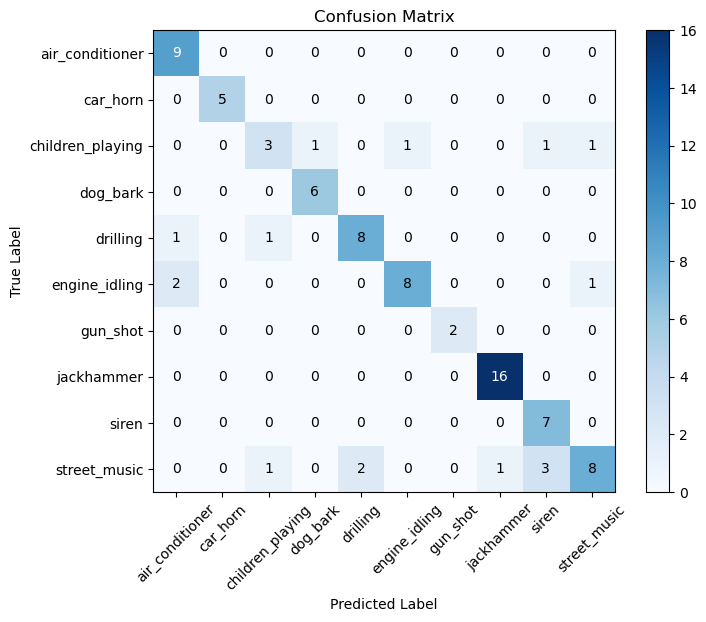

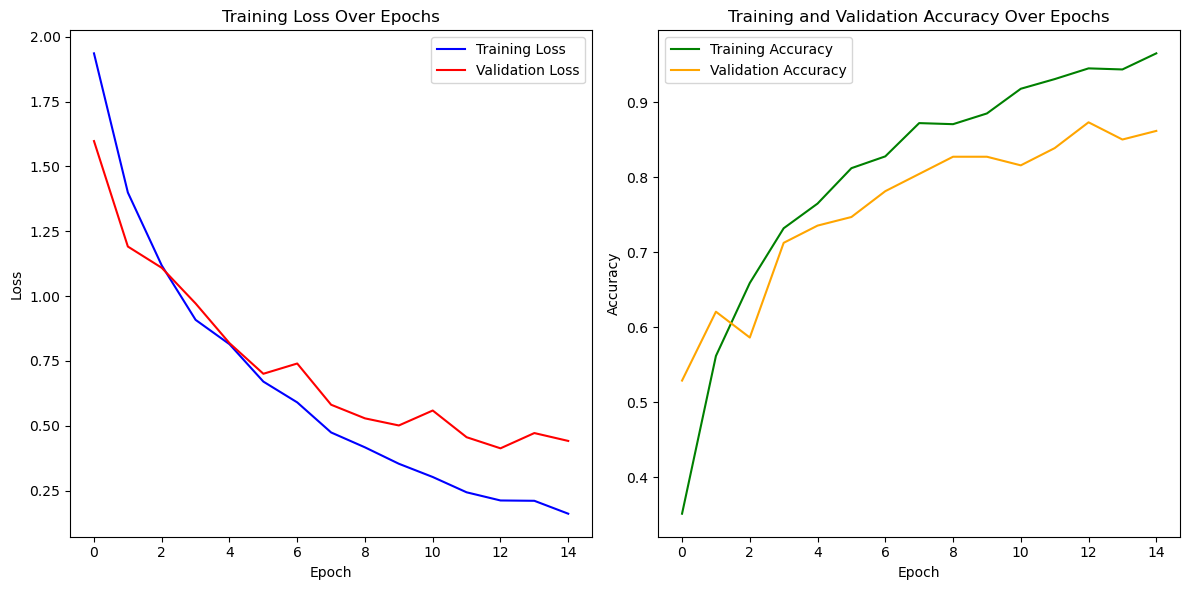

In [35]:
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical

# Convert the class labels to numerical values
label_encoder = LabelEncoder()
Y_df_repetiçao_cnn['class_encoded'] = label_encoder.fit_transform(Y_df_repetiçao_cnn['class'])

dataset_mfcc_repetiçao_cnn=np.array(dataset_mfcc_repetiçao_cnn)

num_classes = len(Y_df['class'].unique())

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(dataset_mfcc_repetiçao_cnn,Y_df_repetiçao_cnn['class_encoded'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert the lists to NumPy arrays
#X_train = np.array(X_train)
#X_test = np.array(X_test)

# Normalize the data
#scaler = StandardScaler()
v=dataset_mfcc_repetiçao_cnn.max()
X_train_scaled = X_train/v
X_test_scaled = X_test/v
X_val_scaled= X_val/v

# Convert the class labels to one-hot encoding
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
y_val_encoded= to_categorical(y_val)


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(n_mfcc, mfcc_time_size, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_scaled,
    y_train_encoded,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_encoded)
)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Display values in each element
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training history - Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### CNN com interpolaçao

In [36]:
import numpy as np
import librosa
import os
import pandas as pd

# Definindo parâmetros
target_sr = 44100
n_mfcc = 15
hop_length = round(target_sr * 0.0125)
win_length = round(target_sr * 0.023)
n_fft = 2**14
mfcc_time_size = 4 * target_sr // hop_length + 1

# Diretório contendo os arquivos de áudio
audio_directory = "C:\\Users\\tiago\\AC2\\sound_datasets\\urbansound8k\\audio\\fold1"

# Lista para armazenar os dados
dataset_mfcc_interpolaçao_cnn = []
Y = []

i = 0

for f in files:
    # Caminho completo para o arquivo de áudio
    audio_path = os.path.join(audio_directory, f)

    # Carregar áudio original
    (sig, rate) = librosa.load(audio_path, sr=None)

    # Resample audio
    sig_resampled = librosa.resample(sig, orig_sr=rate, target_sr=target_sr)

    # Se a duração for inferior a 4 segundos, aplique interpolação
    if len(sig_resampled) < 4 * target_sr:
        # Aplique a interpolação
        y_preemphasized = librosa.effects.preemphasis(sig_resampled)
        duration_target = 4
        speed_factor = len(y_preemphasized) / (duration_target * target_sr)
        y_interpolated = librosa.effects.time_stretch(y_preemphasized, rate=speed_factor)

        # Calcula os MFCCs para o sinal interpolado
        sig_mfcc = librosa.feature.mfcc(y=y_interpolated, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)
    else:
        # Calcula os MFCCs diretamente
        sig_mfcc = librosa.feature.mfcc(y=sig_resampled, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)

    # Adiciona ao conjunto de dados
    dataset_mfcc_interpolaçao_cnn.append(sig_mfcc)

    # Obtém a classe do áudio com base no arquivo de dados
    audio_name = f.split('/')[-1]  # obtém o nome do arquivo
    audio_name = os.path.basename(audio_name)
    audio_class = us.loc[us['slice_file_name'] == audio_name, 'class'].values[0]

    Y.append({'name': audio_name, 'class': audio_class})
    
    i += 1

# Agora, dataset contém os áudios após resampling e interpolação se necessário
# E dataset_mfcc contém os MFCCs correspondentes
Y_df_interpolaçao_cnn = pd.DataFrame(Y)  # Converte a lista Y em um DataFrame do pandas para facilitar a manipulação

Epoch 1/15
22/22 [==============================] - 1s 21ms/step - loss: 1.9727 - accuracy: 0.2851 - val_loss: 1.5666 - val_accuracy: 0.4023
Epoch 2/15
22/22 [==============================] - 0s 16ms/step - loss: 1.3523 - accuracy: 0.5330 - val_loss: 1.2271 - val_accuracy: 0.5057
Epoch 3/15
22/22 [==============================] - 0s 15ms/step - loss: 1.0660 - accuracy: 0.6347 - val_loss: 0.8360 - val_accuracy: 0.7241
Epoch 4/15
22/22 [==============================] - 0s 16ms/step - loss: 0.7915 - accuracy: 0.7693 - val_loss: 0.8217 - val_accuracy: 0.7126
Epoch 5/15
22/22 [==============================] - 0s 15ms/step - loss: 0.7074 - accuracy: 0.7751 - val_loss: 0.5962 - val_accuracy: 0.7931
Epoch 6/15
22/22 [==============================] - 0s 15ms/step - loss: 0.5969 - accuracy: 0.8152 - val_loss: 0.6231 - val_accuracy: 0.8046
Epoch 7/15
22/22 [==============================] - 0s 16ms/step - loss: 0.4717 - accuracy: 0.8711 - val_loss: 0.5419 - val_accuracy: 0.8276
Epoch 8/15
22

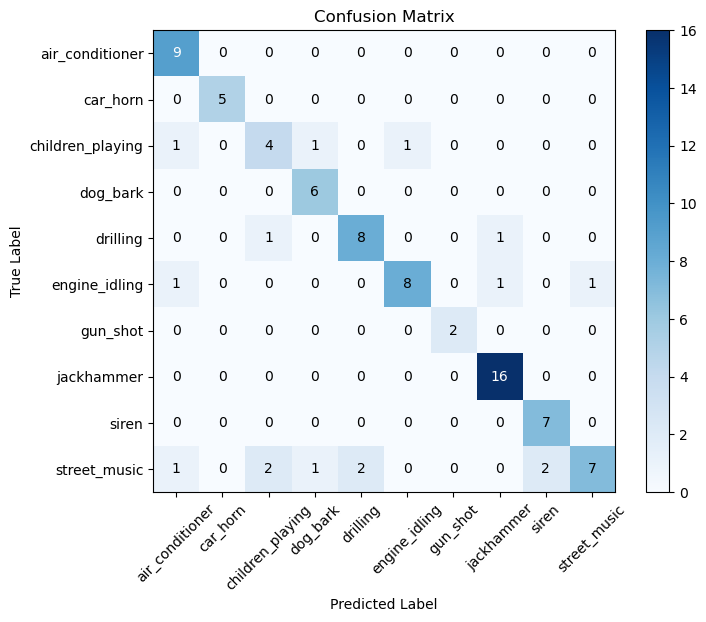

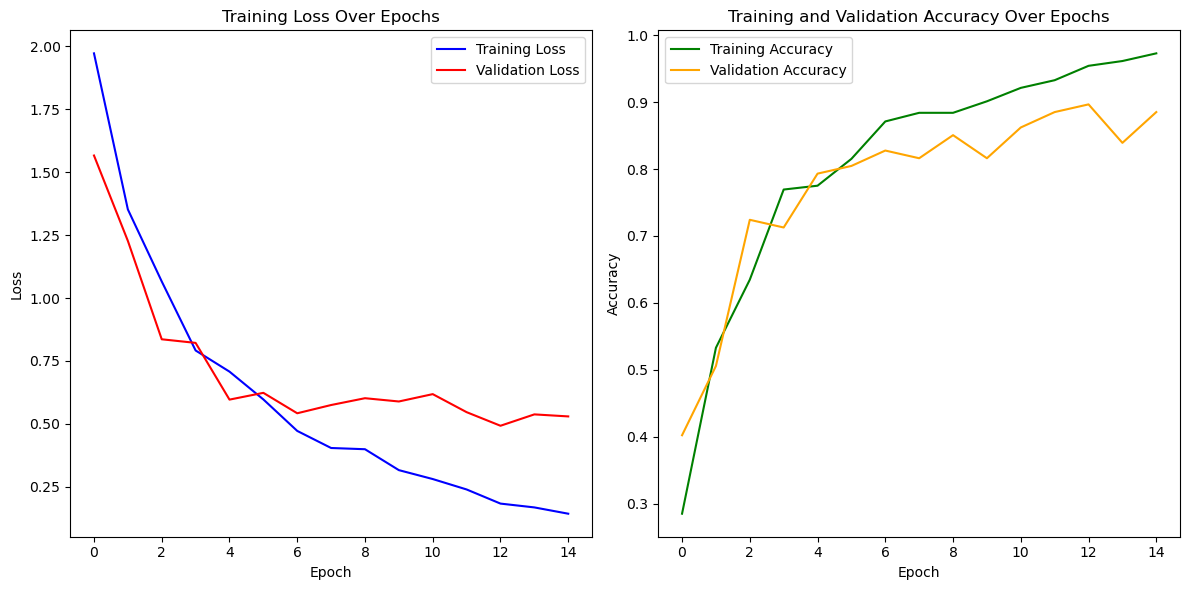

In [37]:
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical

# Convert the class labels to numerical values
label_encoder = LabelEncoder()
Y_df_interpolaçao_cnn['class_encoded'] = label_encoder.fit_transform(Y_df_interpolaçao_cnn['class'])

dataset_mfcc_interpolaçao_cnn=np.array(dataset_mfcc_interpolaçao_cnn)

num_classes = len(Y_df_interpolaçao_cnn['class'].unique())

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(dataset_mfcc_interpolaçao_cnn,Y_df_interpolaçao_cnn['class_encoded'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Normalize the data
v=dataset_mfcc_repetiçao_cnn.max()
X_train_scaled = X_train/v
X_test_scaled = X_test/v
X_val_scaled= X_val/v

# Convert the class labels to one-hot encoding
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
y_val_encoded= to_categorical(y_val)


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(n_mfcc, mfcc_time_size, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_scaled,
    y_train_encoded,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_encoded)
)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Display values in each element
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training history - Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Aplicaçao das melhores estrategias para o dataset inteiro e melhorias nos modelos

## MLP com interpolaçao

In [38]:
import numpy as np
import librosa
import os
import pandas as pd
from scipy.stats import skew, kurtosis

# Definindo parâmetros
target_sr = 44100
n_mfcc = 15
hop_length = round(target_sr * 0.0125)
win_length = round(target_sr * 0.023)
n_fft = 2**14
mfcc_time_size = 4 * target_sr // hop_length + 1

# Diretório contendo os arquivos de áudio
base_directory = "C:\\Users\\tiago\\AC2\\sound_datasets\\urbansound8k\\audio"
folders = [f"fold{i}" for i in range(1, 11)]

# Listas para armazenar os dados de cada fold
datasets_per_fold = []
Y_per_fold = []

for folder in folders:
    # Diretório contendo os arquivos de áudio para a pasta atual
    audio_directory = os.path.join(base_directory, folder)

    # Lista todos os arquivos na pasta atual
    files = os.listdir(audio_directory)

    # Lista para armazenar os dados do fold atual
    dataset_fold = []
    Y_fold = []

    for f in files:
        # Caminho completo para o arquivo de áudio
        audio_path = os.path.join(audio_directory, f)

        # Carregar áudio original
        (sig, rate) = librosa.load(audio_path, sr=None)

        # Resample audio
        sig_resampled = librosa.resample(sig, orig_sr=rate, target_sr=target_sr)

        # Se a duração for inferior a 4 segundos, aplique interpolação
        if len(sig_resampled) < 4 * target_sr:
            y_preemphasized = librosa.effects.preemphasis(sig_resampled)
            duration_target = 4
            speed_factor = len(y_preemphasized) / (duration_target * target_sr)
            y_interpolated = librosa.effects.time_stretch(y_preemphasized, rate=speed_factor)

            # Calcula os MFCCs
            sig_mfcc = librosa.feature.mfcc(y=y_interpolated, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)

            # Calcula estatísticas para cada coeficiente MFCC
            mfcc_stats = np.concatenate([
                np.mean(sig_mfcc, axis=1),
                np.std(sig_mfcc, axis=1),
                skew(sig_mfcc, axis=1),
                kurtosis(sig_mfcc, axis=1),
                np.min(sig_mfcc, axis=1),
                np.max(sig_mfcc, axis=1),
            ])
        else:
            # Calcula os MFCCs diretamente
            sig_mfcc = librosa.feature.mfcc(y=sig_resampled, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)

            # Calcula estatísticas para cada coeficiente MFCC
            mfcc_stats = np.concatenate([
                np.mean(sig_mfcc, axis=1),
                np.std(sig_mfcc, axis=1),
                skew(sig_mfcc, axis=1),
                kurtosis(sig_mfcc, axis=1),
                np.min(sig_mfcc, axis=1),
                np.max(sig_mfcc, axis=1),
            ])

        # Adiciona ao conjunto de dados do fold atual
        dataset_fold.append(mfcc_stats)

        # Obtém a classe do áudio com base no arquivo de dados
        audio_name = f.split('/')[-1]  # obtém o nome do arquivo
        audio_name = os.path.basename(audio_name)
        audio_class = us.loc[us['slice_file_name'] == audio_name, 'class'].values[0]

        Y_fold.append({'name': audio_name, 'class': audio_class})

    # Codificação das classes para o fold atual
    Y_fold_df = pd.DataFrame(Y_fold)
    Y_fold_df['class_encoded'] = label_encoder.fit_transform(Y_fold_df['class'])
    
    # Adiciona os dados do fold atual à lista de datasets por fold
    datasets_per_fold.append(np.array(dataset_fold))
    Y_per_fold.append(pd.DataFrame(Y_fold_df))

# Agora, datasets_per_fold contém os dados de cada fold separadamente
# E Y_per_fold contém os rótulos correspondentes a cada fold

Epoch 1/200
62/62 [==============================] - 1s 7ms/step - loss: 8.8878 - accuracy: 0.2561 - val_loss: 7.7608 - val_accuracy: 0.5258
Epoch 2/200
62/62 [==============================] - 0s 5ms/step - loss: 7.5674 - accuracy: 0.4344 - val_loss: 7.0078 - val_accuracy: 0.5636
Epoch 3/200
62/62 [==============================] - 0s 5ms/step - loss: 6.7848 - accuracy: 0.5101 - val_loss: 6.3618 - val_accuracy: 0.6140
Epoch 4/200
62/62 [==============================] - 0s 5ms/step - loss: 6.0902 - accuracy: 0.5676 - val_loss: 5.8190 - val_accuracy: 0.6071
Epoch 5/200
62/62 [==============================] - 0s 5ms/step - loss: 5.4919 - accuracy: 0.5955 - val_loss: 5.3183 - val_accuracy: 0.6082
Epoch 6/200
62/62 [==============================] - 0s 5ms/step - loss: 4.9454 - accuracy: 0.6274 - val_loss: 4.8487 - val_accuracy: 0.5922
Epoch 7/200
62/62 [==============================] - 0s 5ms/step - loss: 4.4399 - accuracy: 0.6482 - val_loss: 4.4423 - val_accuracy: 0.6014
Epoch 8/200
6

Epoch 17/200
62/62 [==============================] - 0s 5ms/step - loss: 1.6681 - accuracy: 0.7838 - val_loss: 2.1394 - val_accuracy: 0.6216
Epoch 18/200
62/62 [==============================] - 0s 5ms/step - loss: 1.5513 - accuracy: 0.7871 - val_loss: 2.1237 - val_accuracy: 0.5935
Epoch 19/200
62/62 [==============================] - 0s 5ms/step - loss: 1.4158 - accuracy: 0.8060 - val_loss: 2.0910 - val_accuracy: 0.5946
Epoch 20/200
62/62 [==============================] - 0s 5ms/step - loss: 1.3424 - accuracy: 0.8041 - val_loss: 1.9922 - val_accuracy: 0.6250
Epoch 21/200
62/62 [==============================] - 0s 5ms/step - loss: 1.2555 - accuracy: 0.8145 - val_loss: 1.9563 - val_accuracy: 0.6250
Epoch 22/200
62/62 [==============================] - 0s 5ms/step - loss: 1.2004 - accuracy: 0.8182 - val_loss: 2.0184 - val_accuracy: 0.6014
Epoch 23/200
62/62 [==============================] - 0s 5ms/step - loss: 1.1547 - accuracy: 0.8202 - val_loss: 1.8312 - val_accuracy: 0.6250
Epoch 

Epoch 26/200
61/61 [==============================] - 0s 5ms/step - loss: 0.9905 - accuracy: 0.8433 - val_loss: 2.0048 - val_accuracy: 0.5297
Epoch 27/200
61/61 [==============================] - 0s 5ms/step - loss: 0.9357 - accuracy: 0.8531 - val_loss: 2.0526 - val_accuracy: 0.5405
Epoch 28/200
61/61 [==============================] - 0s 6ms/step - loss: 0.9307 - accuracy: 0.8499 - val_loss: 2.0818 - val_accuracy: 0.5492
Epoch 29/200
61/61 [==============================] - 0s 7ms/step - loss: 0.9005 - accuracy: 0.8555 - val_loss: 2.1203 - val_accuracy: 0.5308
Epoch 30/200
61/61 [==============================] - 0s 5ms/step - loss: 0.8742 - accuracy: 0.8551 - val_loss: 2.0040 - val_accuracy: 0.5405
Epoch 31/200
61/61 [==============================] - 0s 6ms/step - loss: 0.8488 - accuracy: 0.8522 - val_loss: 2.1915 - val_accuracy: 0.5330
Epoch 32/200
61/61 [==============================] - 0s 6ms/step - loss: 0.8313 - accuracy: 0.8627 - val_loss: 2.1163 - val_accuracy: 0.5362
Epoch 

Epoch 50/200
61/61 [==============================] - 0s 5ms/step - loss: 0.6641 - accuracy: 0.8880 - val_loss: 1.9178 - val_accuracy: 0.6566
Epoch 51/200
61/61 [==============================] - 0s 5ms/step - loss: 0.6597 - accuracy: 0.8871 - val_loss: 1.9058 - val_accuracy: 0.6545
Epoch 52/200
61/61 [==============================] - 0s 5ms/step - loss: 0.6461 - accuracy: 0.8931 - val_loss: 1.9045 - val_accuracy: 0.6556
Epoch 53/200
31/31 [==============================] - 0s 1ms/step - loss: 1.7084 - accuracy: 0.6384
Accuracy for Fold 4: 0.6383838653564453
Epoch 1/200
61/61 [==============================] - 2s 8ms/step - loss: 8.8391 - accuracy: 0.2762 - val_loss: 7.7887 - val_accuracy: 0.4989
Epoch 2/200
61/61 [==============================] - 0s 5ms/step - loss: 7.6153 - accuracy: 0.4384 - val_loss: 7.0382 - val_accuracy: 0.5267
Epoch 3/200
61/61 [==============================] - 0s 5ms/step - loss: 6.8449 - accuracy: 0.5064 - val_loss: 6.3952 - val_accuracy: 0.5620
Epoch 4/200

62/62 [==============================] - 0s 5ms/step - loss: 4.4009 - accuracy: 0.6606 - val_loss: 4.3121 - val_accuracy: 0.6100
Epoch 8/200
62/62 [==============================] - 0s 5ms/step - loss: 3.9364 - accuracy: 0.6818 - val_loss: 3.9262 - val_accuracy: 0.6100
Epoch 9/200
62/62 [==============================] - 0s 5ms/step - loss: 3.5279 - accuracy: 0.7012 - val_loss: 3.5956 - val_accuracy: 0.6124
Epoch 10/200
62/62 [==============================] - 0s 5ms/step - loss: 3.1573 - accuracy: 0.7140 - val_loss: 3.2751 - val_accuracy: 0.6185
Epoch 11/200
62/62 [==============================] - 0s 5ms/step - loss: 2.8290 - accuracy: 0.7399 - val_loss: 2.9822 - val_accuracy: 0.6343
Epoch 12/200
62/62 [==============================] - 0s 5ms/step - loss: 2.5680 - accuracy: 0.7436 - val_loss: 2.7818 - val_accuracy: 0.6294
Epoch 13/200
62/62 [==============================] - 0s 5ms/step - loss: 2.3369 - accuracy: 0.7532 - val_loss: 2.5811 - val_accuracy: 0.6525
Epoch 14/200
62/62 [=

Epoch 15/200
62/62 [==============================] - 0s 5ms/step - loss: 1.9746 - accuracy: 0.7743 - val_loss: 2.1606 - val_accuracy: 0.6885
Epoch 16/200
62/62 [==============================] - 0s 5ms/step - loss: 1.7988 - accuracy: 0.7906 - val_loss: 2.0414 - val_accuracy: 0.6778
Epoch 17/200
62/62 [==============================] - 0s 5ms/step - loss: 1.6618 - accuracy: 0.7959 - val_loss: 1.9294 - val_accuracy: 0.6897
Epoch 18/200
62/62 [==============================] - 0s 5ms/step - loss: 1.5407 - accuracy: 0.7991 - val_loss: 1.8822 - val_accuracy: 0.6778
Epoch 19/200
62/62 [==============================] - 0s 5ms/step - loss: 1.4332 - accuracy: 0.8091 - val_loss: 1.7188 - val_accuracy: 0.6981
Epoch 20/200
62/62 [==============================] - 0s 5ms/step - loss: 1.3523 - accuracy: 0.8145 - val_loss: 1.6680 - val_accuracy: 0.7005
Epoch 21/200
62/62 [==============================] - 0s 5ms/step - loss: 1.2690 - accuracy: 0.8196 - val_loss: 1.5982 - val_accuracy: 0.7017
Epoch 

Epoch 28/200
62/62 [==============================] - 0s 5ms/step - loss: 0.8992 - accuracy: 0.8521 - val_loss: 1.7196 - val_accuracy: 0.6303
Epoch 29/200
62/62 [==============================] - 0s 5ms/step - loss: 0.8901 - accuracy: 0.8518 - val_loss: 1.6229 - val_accuracy: 0.6873
Epoch 30/200
62/62 [==============================] - 0s 5ms/step - loss: 0.8477 - accuracy: 0.8564 - val_loss: 1.7896 - val_accuracy: 0.6414
Epoch 31/200
62/62 [==============================] - 0s 5ms/step - loss: 0.8176 - accuracy: 0.8630 - val_loss: 1.8393 - val_accuracy: 0.6625
Epoch 32/200
62/62 [==============================] - 0s 5ms/step - loss: 0.8287 - accuracy: 0.8576 - val_loss: 1.8139 - val_accuracy: 0.6551
Epoch 33/200
62/62 [==============================] - 0s 5ms/step - loss: 0.8044 - accuracy: 0.8618 - val_loss: 1.7292 - val_accuracy: 0.6613
Epoch 34/200
62/62 [==============================] - 0s 5ms/step - loss: 0.7871 - accuracy: 0.8688 - val_loss: 1.8312 - val_accuracy: 0.6117
Epoch 

Epoch 48/200
62/62 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.8809 - val_loss: 1.7022 - val_accuracy: 0.6936
Epoch 49/200
62/62 [==============================] - 0s 5ms/step - loss: 0.6743 - accuracy: 0.8872 - val_loss: 1.6604 - val_accuracy: 0.6912
Epoch 50/200
62/62 [==============================] - 0s 5ms/step - loss: 0.6548 - accuracy: 0.8936 - val_loss: 1.6677 - val_accuracy: 0.6949
Epoch 51/200
62/62 [==============================] - 0s 5ms/step - loss: 0.6696 - accuracy: 0.8868 - val_loss: 1.6260 - val_accuracy: 0.7047
Epoch 52/200
62/62 [==============================] - 0s 5ms/step - loss: 0.6663 - accuracy: 0.8895 - val_loss: 1.6158 - val_accuracy: 0.6924
Epoch 53/200
62/62 [==============================] - 0s 5ms/step - loss: 0.6533 - accuracy: 0.8914 - val_loss: 1.6137 - val_accuracy: 0.7010
Epoch 54/200
62/62 [==============================] - 0s 5ms/step - loss: 0.6506 - accuracy: 0.8965 - val_loss: 1.7204 - val_accuracy: 0.6814
Epoch 

Epoch 42/200
62/62 [==============================] - 0s 5ms/step - loss: 0.7162 - accuracy: 0.8770 - val_loss: 1.7764 - val_accuracy: 0.6464
Epoch 43/200
62/62 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.8780 - val_loss: 1.7238 - val_accuracy: 0.6511
Epoch 44/200
27/27 [==============================] - 0s 1ms/step - loss: 1.5765 - accuracy: 0.6703
Accuracy for Fold 10: 0.6702508926391602

Mean Accuracy: 0.6618393778800964
Standard Deviation of Accuracy: 0.0496271412164199


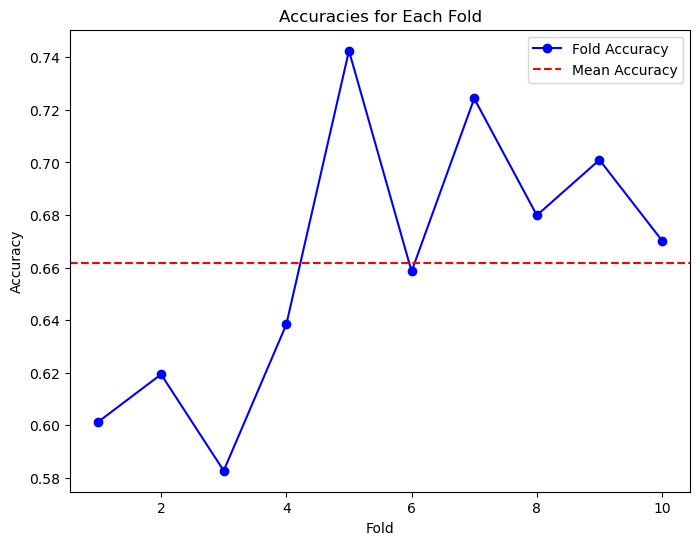

In [69]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Função para criar o modelo
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Lista para armazenar as métricas de desempenho
accuracies = []

# Loop para cada fold
for fold_idx in range(10):
    # Substituir pelos nomes corretos das suas variáveis
    X_test = datasets_per_fold[fold_idx]
    y_test = Y_per_fold[fold_idx]['class_encoded']

    X_train = np.concatenate([datasets_per_fold[i] for i in range(10) if i != fold_idx])
    y_train = pd.concat([Y_per_fold[i] for i in range(10) if i != fold_idx])['class_encoded']

    # Calcular os pesos das classes
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Criar e treinar o modelo
    model = create_model(X_train_scaled.shape[1], len(np.unique(y_train)))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_scaled, 
        y_train, 
        validation_data=(X_test_scaled, y_test), 
        epochs=200, 
        batch_size=128, 
        class_weight=class_weight_dict,
        callbacks=[early_stopping]
    )

    # Avaliar o modelo
    _, accuracy = model.evaluate(X_test_scaled, y_test)
    print(f"Accuracy for Fold {fold_idx + 1}: {accuracy}")
    accuracies.append(accuracy)

# Média e desvio padrão das acurácias
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"\nMean Accuracy: {mean_accuracy}")
print(f"Standard Deviation of Accuracy: {std_accuracy}")

# Plotar os valores de acurácia para cada fold
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), accuracies, marker='o', linestyle='-', color='b', label='Fold Accuracy')


# Adicionar uma linha para a média
plt.axhline(y=mean_accuracy, color='red', linestyle='--', label='Mean Accuracy')

# Adicionar rótulos e título ao gráfico
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracies for Each Fold')
plt.legend()
plt.show()

Epoch 1/200
42/42 [==============================] - 2s 10ms/step - loss: 6.0173 - accuracy: 0.2321 - val_loss: 4.9868 - val_accuracy: 0.5089
Epoch 2/200
42/42 [==============================] - 0s 6ms/step - loss: 5.1183 - accuracy: 0.3801 - val_loss: 4.6449 - val_accuracy: 0.5690
Epoch 3/200
42/42 [==============================] - 0s 6ms/step - loss: 4.7528 - accuracy: 0.4427 - val_loss: 4.3739 - val_accuracy: 0.6180
Epoch 4/200
42/42 [==============================] - 0s 6ms/step - loss: 4.4957 - accuracy: 0.5033 - val_loss: 4.1491 - val_accuracy: 0.6442
Epoch 5/200
42/42 [==============================] - 0s 6ms/step - loss: 4.2436 - accuracy: 0.5489 - val_loss: 3.9662 - val_accuracy: 0.6650
Epoch 6/200
42/42 [==============================] - 0s 6ms/step - loss: 4.0759 - accuracy: 0.5632 - val_loss: 3.7877 - val_accuracy: 0.6893
Epoch 7/200
42/42 [==============================] - 0s 6ms/step - loss: 3.9248 - accuracy: 0.5829 - val_loss: 3.6355 - val_accuracy: 0.7043
Epoch 8/200


Epoch 59/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7688 - accuracy: 0.8815 - val_loss: 0.8141 - val_accuracy: 0.8824
Epoch 60/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7432 - accuracy: 0.8874 - val_loss: 0.8013 - val_accuracy: 0.8897
Epoch 61/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7166 - accuracy: 0.8942 - val_loss: 0.7907 - val_accuracy: 0.8863
Epoch 62/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7330 - accuracy: 0.8832 - val_loss: 0.8004 - val_accuracy: 0.8809
Epoch 63/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7290 - accuracy: 0.8813 - val_loss: 0.8039 - val_accuracy: 0.8851
Epoch 64/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7031 - accuracy: 0.8900 - val_loss: 0.8017 - val_accuracy: 0.8778
Epoch 65/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6897 - accuracy: 0.8942 - val_loss: 0.7673 - val_accuracy: 0.8909
Epoch 

Epoch 11/200
42/42 [==============================] - 0s 6ms/step - loss: 3.4689 - accuracy: 0.6301 - val_loss: 3.2392 - val_accuracy: 0.7300
Epoch 12/200
42/42 [==============================] - 0s 6ms/step - loss: 3.3843 - accuracy: 0.6445 - val_loss: 3.1457 - val_accuracy: 0.7393
Epoch 13/200
42/42 [==============================] - 0s 6ms/step - loss: 3.2599 - accuracy: 0.6580 - val_loss: 3.0539 - val_accuracy: 0.7509
Epoch 14/200
42/42 [==============================] - 0s 6ms/step - loss: 3.1855 - accuracy: 0.6653 - val_loss: 2.9648 - val_accuracy: 0.7536
Epoch 15/200
42/42 [==============================] - 0s 6ms/step - loss: 3.0503 - accuracy: 0.6803 - val_loss: 2.8698 - val_accuracy: 0.7640
Epoch 16/200
42/42 [==============================] - 0s 6ms/step - loss: 2.9621 - accuracy: 0.6807 - val_loss: 2.7863 - val_accuracy: 0.7694
Epoch 17/200
42/42 [==============================] - 0s 6ms/step - loss: 2.8759 - accuracy: 0.6908 - val_loss: 2.7061 - val_accuracy: 0.7710
Epoch 

Epoch 69/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9903 - accuracy: 0.8422 - val_loss: 1.0002 - val_accuracy: 0.8598
Epoch 70/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9799 - accuracy: 0.8426 - val_loss: 0.9967 - val_accuracy: 0.8598
Epoch 71/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9648 - accuracy: 0.8518 - val_loss: 0.9676 - val_accuracy: 0.8617
Epoch 72/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9319 - accuracy: 0.8615 - val_loss: 0.9694 - val_accuracy: 0.8606
Epoch 73/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9588 - accuracy: 0.8379 - val_loss: 0.9686 - val_accuracy: 0.8582
Epoch 74/200
42/42 [==============================] - 0s 6ms/step - loss: 0.8874 - accuracy: 0.8691 - val_loss: 0.9335 - val_accuracy: 0.8617
Epoch 75/200
42/42 [==============================] - 0s 6ms/step - loss: 0.8945 - accuracy: 0.8655 - val_loss: 0.9280 - val_accuracy: 0.8629
Epoch 

Epoch 14/200
41/41 [==============================] - 0s 6ms/step - loss: 2.8901 - accuracy: 0.6912 - val_loss: 2.6511 - val_accuracy: 0.7893
Epoch 15/200
41/41 [==============================] - 0s 6ms/step - loss: 2.7836 - accuracy: 0.6967 - val_loss: 2.5494 - val_accuracy: 0.7881
Epoch 16/200
41/41 [==============================] - 0s 6ms/step - loss: 2.6679 - accuracy: 0.7151 - val_loss: 2.4416 - val_accuracy: 0.7955
Epoch 17/200
41/41 [==============================] - 0s 6ms/step - loss: 2.5491 - accuracy: 0.7241 - val_loss: 2.3486 - val_accuracy: 0.8009
Epoch 18/200
41/41 [==============================] - 0s 6ms/step - loss: 2.4295 - accuracy: 0.7463 - val_loss: 2.2451 - val_accuracy: 0.8083
Epoch 19/200
41/41 [==============================] - 0s 6ms/step - loss: 2.3240 - accuracy: 0.7402 - val_loss: 2.1618 - val_accuracy: 0.8056
Epoch 20/200
41/41 [==============================] - 0s 6ms/step - loss: 2.2460 - accuracy: 0.7489 - val_loss: 2.0789 - val_accuracy: 0.8130
Epoch 

Epoch 72/200
41/41 [==============================] - 0s 7ms/step - loss: 0.5758 - accuracy: 0.9136 - val_loss: 0.6527 - val_accuracy: 0.8976
Epoch 73/200
41/41 [==============================] - 0s 6ms/step - loss: 0.5707 - accuracy: 0.9140 - val_loss: 0.6560 - val_accuracy: 0.8972
Epoch 74/200
41/41 [==============================] - 0s 6ms/step - loss: 0.5599 - accuracy: 0.9151 - val_loss: 0.6376 - val_accuracy: 0.8952
Epoch 75/200
41/41 [==============================] - 0s 6ms/step - loss: 0.5586 - accuracy: 0.9159 - val_loss: 0.6530 - val_accuracy: 0.8929
Epoch 76/200
41/41 [==============================] - 0s 6ms/step - loss: 0.5640 - accuracy: 0.9157 - val_loss: 0.6515 - val_accuracy: 0.8960
Epoch 77/200
41/41 [==============================] - 0s 6ms/step - loss: 0.5458 - accuracy: 0.9187 - val_loss: 0.6421 - val_accuracy: 0.8983
Epoch 78/200
41/41 [==============================] - 0s 6ms/step - loss: 0.5517 - accuracy: 0.9199 - val_loss: 0.6340 - val_accuracy: 0.8956
Epoch 

Epoch 62/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6491 - accuracy: 0.9011 - val_loss: 0.7112 - val_accuracy: 0.8877
Epoch 63/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6257 - accuracy: 0.9044 - val_loss: 0.7109 - val_accuracy: 0.8885
Epoch 64/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6331 - accuracy: 0.9017 - val_loss: 0.7152 - val_accuracy: 0.8849
Epoch 65/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6348 - accuracy: 0.9003 - val_loss: 0.7053 - val_accuracy: 0.8885
Epoch 66/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6152 - accuracy: 0.9090 - val_loss: 0.6877 - val_accuracy: 0.8947
Epoch 67/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6186 - accuracy: 0.9046 - val_loss: 0.7012 - val_accuracy: 0.8869
Epoch 68/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6046 - accuracy: 0.9073 - val_loss: 0.6780 - val_accuracy: 0.8900
Epoch 

Epoch 2/200
41/41 [==============================] - 0s 6ms/step - loss: 5.1402 - accuracy: 0.3789 - val_loss: 4.6571 - val_accuracy: 0.5503
Epoch 3/200
41/41 [==============================] - 0s 6ms/step - loss: 4.7677 - accuracy: 0.4474 - val_loss: 4.3967 - val_accuracy: 0.6001
Epoch 4/200
41/41 [==============================] - 0s 6ms/step - loss: 4.5268 - accuracy: 0.4911 - val_loss: 4.1668 - val_accuracy: 0.6257
Epoch 5/200
41/41 [==============================] - 0s 6ms/step - loss: 4.2947 - accuracy: 0.5332 - val_loss: 3.9753 - val_accuracy: 0.6529
Epoch 6/200
41/41 [==============================] - 0s 6ms/step - loss: 4.0870 - accuracy: 0.5669 - val_loss: 3.8085 - val_accuracy: 0.6693
Epoch 7/200
41/41 [==============================] - 0s 6ms/step - loss: 3.9338 - accuracy: 0.5797 - val_loss: 3.6396 - val_accuracy: 0.6883
Epoch 8/200
41/41 [==============================] - 0s 6ms/step - loss: 3.7919 - accuracy: 0.5958 - val_loss: 3.4903 - val_accuracy: 0.7143
Epoch 9/200
4

Epoch 60/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6850 - accuracy: 0.8943 - val_loss: 0.7773 - val_accuracy: 0.8819
Epoch 61/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6605 - accuracy: 0.8970 - val_loss: 0.7603 - val_accuracy: 0.8819
Epoch 62/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6652 - accuracy: 0.8970 - val_loss: 0.7493 - val_accuracy: 0.8881
Epoch 63/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6618 - accuracy: 0.8985 - val_loss: 0.7653 - val_accuracy: 0.8873
Epoch 64/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6697 - accuracy: 0.8958 - val_loss: 0.7657 - val_accuracy: 0.8838
Epoch 65/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6351 - accuracy: 0.9050 - val_loss: 0.7560 - val_accuracy: 0.8861
Epoch 66/200
41/41 [==============================] - 0s 6ms/step - loss: 0.6386 - accuracy: 0.8995 - val_loss: 0.7430 - val_accuracy: 0.8846
Epoch 

Epoch 40/200
42/42 [==============================] - 0s 6ms/step - loss: 1.0034 - accuracy: 0.8617 - val_loss: 1.0223 - val_accuracy: 0.8670
Epoch 41/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9858 - accuracy: 0.8585 - val_loss: 1.0050 - val_accuracy: 0.8674
Epoch 42/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9438 - accuracy: 0.8696 - val_loss: 0.9875 - val_accuracy: 0.8586
Epoch 43/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9102 - accuracy: 0.8717 - val_loss: 0.9507 - val_accuracy: 0.8713
Epoch 44/200
42/42 [==============================] - 0s 6ms/step - loss: 0.8801 - accuracy: 0.8721 - val_loss: 0.9343 - val_accuracy: 0.8724
Epoch 45/200
42/42 [==============================] - 0s 6ms/step - loss: 0.8762 - accuracy: 0.8668 - val_loss: 0.9202 - val_accuracy: 0.8732
Epoch 46/200
42/42 [==============================] - 0s 6ms/step - loss: 0.8439 - accuracy: 0.8762 - val_loss: 0.9035 - val_accuracy: 0.8705
Epoch 

Epoch 98/200
42/42 [==============================] - 0s 6ms/step - loss: 0.5024 - accuracy: 0.9202 - val_loss: 0.6605 - val_accuracy: 0.8862
Epoch 99/200
42/42 [==============================] - 0s 6ms/step - loss: 0.4784 - accuracy: 0.9300 - val_loss: 0.6769 - val_accuracy: 0.8851
Epoch 100/200
42/42 [==============================] - 0s 6ms/step - loss: 0.5012 - accuracy: 0.9268 - val_loss: 0.6651 - val_accuracy: 0.8854
Epoch 101/200
42/42 [==============================] - 0s 6ms/step - loss: 0.4862 - accuracy: 0.9292 - val_loss: 0.6484 - val_accuracy: 0.8958
Epoch 102/200
42/42 [==============================] - 0s 6ms/step - loss: 0.4798 - accuracy: 0.9309 - val_loss: 0.6600 - val_accuracy: 0.8931
Epoch 103/200
42/42 [==============================] - 0s 6ms/step - loss: 0.4853 - accuracy: 0.9277 - val_loss: 0.6423 - val_accuracy: 0.9015
Epoch 104/200
42/42 [==============================] - 0s 6ms/step - loss: 0.4597 - accuracy: 0.9358 - val_loss: 0.6392 - val_accuracy: 0.9023
E

Epoch 39/200
42/42 [==============================] - 0s 6ms/step - loss: 1.1064 - accuracy: 0.8376 - val_loss: 1.0918 - val_accuracy: 0.8561
Epoch 40/200
42/42 [==============================] - 0s 7ms/step - loss: 1.0640 - accuracy: 0.8521 - val_loss: 1.0572 - val_accuracy: 0.8634
Epoch 41/200
42/42 [==============================] - 0s 6ms/step - loss: 1.0509 - accuracy: 0.8559 - val_loss: 1.0432 - val_accuracy: 0.8557
Epoch 42/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9832 - accuracy: 0.8610 - val_loss: 1.0012 - val_accuracy: 0.8642
Epoch 43/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9687 - accuracy: 0.8612 - val_loss: 0.9795 - val_accuracy: 0.8665
Epoch 44/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9489 - accuracy: 0.8642 - val_loss: 0.9676 - val_accuracy: 0.8592
Epoch 45/200
42/42 [==============================] - 0s 6ms/step - loss: 0.9305 - accuracy: 0.8644 - val_loss: 0.9451 - val_accuracy: 0.8688
Epoch 

Epoch 3/200
42/42 [==============================] - 0s 6ms/step - loss: 4.7150 - accuracy: 0.4580 - val_loss: 4.3509 - val_accuracy: 0.6158
Epoch 4/200
42/42 [==============================] - 0s 6ms/step - loss: 4.4236 - accuracy: 0.5124 - val_loss: 4.1236 - val_accuracy: 0.6453
Epoch 5/200
42/42 [==============================] - 0s 6ms/step - loss: 4.2319 - accuracy: 0.5427 - val_loss: 3.9193 - val_accuracy: 0.6644
Epoch 6/200
42/42 [==============================] - 0s 6ms/step - loss: 4.0093 - accuracy: 0.5810 - val_loss: 3.7407 - val_accuracy: 0.6843
Epoch 7/200
42/42 [==============================] - 0s 6ms/step - loss: 3.8336 - accuracy: 0.6015 - val_loss: 3.5809 - val_accuracy: 0.6965
Epoch 8/200
42/42 [==============================] - 0s 6ms/step - loss: 3.6568 - accuracy: 0.6235 - val_loss: 3.4315 - val_accuracy: 0.7144
Epoch 9/200
42/42 [==============================] - 0s 6ms/step - loss: 3.5172 - accuracy: 0.6343 - val_loss: 3.2856 - val_accuracy: 0.7221
Epoch 10/200


Epoch 61/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6434 - accuracy: 0.8996 - val_loss: 0.7404 - val_accuracy: 0.8788
Epoch 62/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6228 - accuracy: 0.9139 - val_loss: 0.7354 - val_accuracy: 0.8819
Epoch 63/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6426 - accuracy: 0.8979 - val_loss: 0.7300 - val_accuracy: 0.8842
Epoch 64/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6237 - accuracy: 0.9115 - val_loss: 0.7276 - val_accuracy: 0.8819
Epoch 65/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6096 - accuracy: 0.9094 - val_loss: 0.7179 - val_accuracy: 0.8891
Epoch 66/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6107 - accuracy: 0.9038 - val_loss: 0.7037 - val_accuracy: 0.8914
Epoch 67/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6105 - accuracy: 0.9064 - val_loss: 0.6956 - val_accuracy: 0.8899
Epoch 

Epoch 45/200
42/42 [==============================] - 0s 6ms/step - loss: 0.8893 - accuracy: 0.8737 - val_loss: 0.9450 - val_accuracy: 0.8657
Epoch 46/200
42/42 [==============================] - 0s 6ms/step - loss: 0.8797 - accuracy: 0.8716 - val_loss: 0.9253 - val_accuracy: 0.8607
Epoch 47/200
42/42 [==============================] - 0s 6ms/step - loss: 0.8438 - accuracy: 0.8837 - val_loss: 0.8944 - val_accuracy: 0.8718
Epoch 48/200
42/42 [==============================] - 0s 6ms/step - loss: 0.8161 - accuracy: 0.8801 - val_loss: 0.8780 - val_accuracy: 0.8756
Epoch 49/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7914 - accuracy: 0.8869 - val_loss: 0.8674 - val_accuracy: 0.8768
Epoch 50/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7878 - accuracy: 0.8869 - val_loss: 0.8363 - val_accuracy: 0.8852
Epoch 51/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7811 - accuracy: 0.8870 - val_loss: 0.8513 - val_accuracy: 0.8699
Epoch 

Epoch 103/200
42/42 [==============================] - 0s 6ms/step - loss: 0.4927 - accuracy: 0.9314 - val_loss: 0.6765 - val_accuracy: 0.8902
Epoch 104/200
42/42 [==============================] - 0s 6ms/step - loss: 0.4850 - accuracy: 0.9321 - val_loss: 0.6635 - val_accuracy: 0.8860
Epoch 105/200
42/42 [==============================] - 0s 6ms/step - loss: 0.4771 - accuracy: 0.9317 - val_loss: 0.6533 - val_accuracy: 0.8913
Epoch 106/200
42/42 [==============================] - 0s 6ms/step - loss: 0.4875 - accuracy: 0.9310 - val_loss: 0.6483 - val_accuracy: 0.8928
Epoch 107/200
26/26 [==============================] - 0s 1ms/step - loss: 1.8768 - accuracy: 0.6728
Accuracy for Fold 9: 0.6727941036224365
Epoch 1/200
42/42 [==============================] - 1s 9ms/step - loss: 5.9066 - accuracy: 0.2396 - val_loss: 5.0177 - val_accuracy: 0.4743
Epoch 2/200
42/42 [==============================] - 0s 6ms/step - loss: 5.0666 - accuracy: 0.3891 - val_loss: 4.6588 - val_accuracy: 0.5284
Epoch

Epoch 53/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7203 - accuracy: 0.8934 - val_loss: 0.8128 - val_accuracy: 0.8776
Epoch 54/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7151 - accuracy: 0.8947 - val_loss: 0.7929 - val_accuracy: 0.8772
Epoch 55/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7116 - accuracy: 0.8919 - val_loss: 0.7830 - val_accuracy: 0.8837
Epoch 56/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7188 - accuracy: 0.8883 - val_loss: 0.7674 - val_accuracy: 0.8864
Epoch 57/200
42/42 [==============================] - 0s 6ms/step - loss: 0.7055 - accuracy: 0.8881 - val_loss: 0.7651 - val_accuracy: 0.8880
Epoch 58/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6827 - accuracy: 0.8939 - val_loss: 0.7547 - val_accuracy: 0.8887
Epoch 59/200
42/42 [==============================] - 0s 6ms/step - loss: 0.6815 - accuracy: 0.8936 - val_loss: 0.7596 - val_accuracy: 0.8757
Epoch 

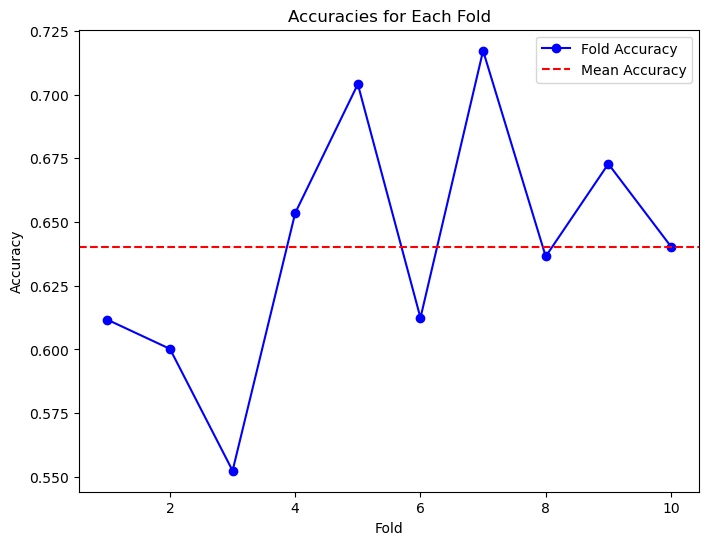

In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Função para criar o modelo
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005), input_shape=(input_shape,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Lista para armazenar as métricas de desempenho
accuracies = []

# Loop para cada fold
for fold_idx in range(10):
    # Substituir pelos nomes corretos das suas variáveis
    X_test = datasets_per_fold[fold_idx]
    y_test = Y_per_fold[fold_idx]['class_encoded']

    # Dividir os dados restantes em treino e validação
    X_remaining, X_val, y_remaining, y_val = train_test_split(
        np.concatenate([datasets_per_fold[i] for i in range(10) if i != fold_idx]),
        pd.concat([Y_per_fold[i] for i in range(10) if i != fold_idx])['class_encoded'],
        test_size=0.33, random_state=42
    )

    # Calcular os pesos das classes
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_remaining), y=y_remaining)
    class_weight_dict = dict(enumerate(class_weights))

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_remaining)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Criar e treinar o modelo
    model = create_model(X_train_scaled.shape[1], len(np.unique(y_remaining)))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_scaled, 
        y_remaining, 
        validation_data=(X_val_scaled, y_val), 
        epochs=200, 
        batch_size=128, 
        class_weight=class_weight_dict,
        callbacks=[early_stopping]
    )

    # Avaliar o modelo
    _, accuracy = model.evaluate(X_test_scaled, y_test)
    print(f"Accuracy for Fold {fold_idx + 1}: {accuracy}")
    accuracies.append(accuracy)

# Média e desvio padrão das acurácias
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"\nMean Accuracy: {mean_accuracy}")
print(f"Standard Deviation of Accuracy: {std_accuracy}")

# Plotar os valores de acurácia para cada fold
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), accuracies, marker='o', linestyle='-', color='b', label='Fold Accuracy')

# Adicionar uma linha para a média
plt.axhline(y=mean_accuracy, color='red', linestyle='--', label='Mean Accuracy')

# Adicionar rótulos e título ao gráfico
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracies for Each Fold')
plt.legend()

# Mostrar o gráfico
plt.show()


Epoch 1/100
124/124 [==============================] - 2s 5ms/step - loss: 5.5378 - accuracy: 0.2981 - val_loss: 4.6610 - val_accuracy: 0.4857
Epoch 2/100
124/124 [==============================] - 1s 5ms/step - loss: 4.6445 - accuracy: 0.4673 - val_loss: 4.2253 - val_accuracy: 0.5609
Epoch 3/100
124/124 [==============================] - 1s 4ms/step - loss: 4.1803 - accuracy: 0.5397 - val_loss: 3.9047 - val_accuracy: 0.5632
Epoch 4/100
124/124 [==============================] - 1s 4ms/step - loss: 3.8345 - accuracy: 0.5828 - val_loss: 3.6276 - val_accuracy: 0.5919
Epoch 5/100
124/124 [==============================] - 1s 4ms/step - loss: 3.5236 - accuracy: 0.6209 - val_loss: 3.3830 - val_accuracy: 0.6301
Epoch 6/100
124/124 [==============================] - 1s 4ms/step - loss: 3.2301 - accuracy: 0.6475 - val_loss: 3.1602 - val_accuracy: 0.6420
Epoch 7/100
124/124 [==============================] - 1s 4ms/step - loss: 2.9821 - accuracy: 0.6723 - val_loss: 2.9455 - val_accuracy: 0.6408

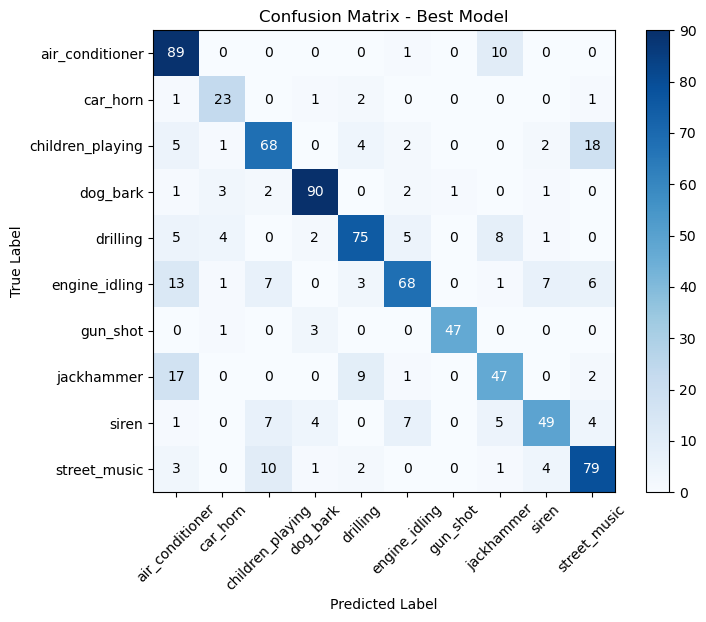

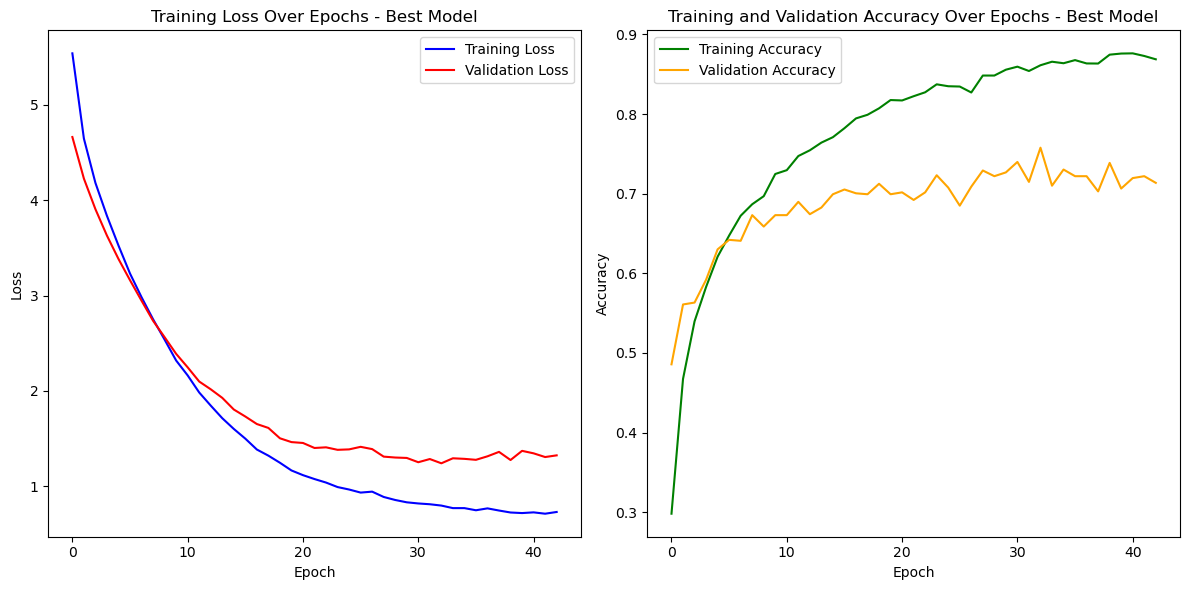

In [71]:
# Encontrar o índice do fold com a melhor acurácia
best_fold_idx = np.argmax(accuracies)

# Substituir pelos nomes corretos das suas variáveis
X_test_best = datasets_per_fold[best_fold_idx]
y_test_best = Y_per_fold[best_fold_idx]['class_encoded']

X_train_best = np.concatenate([datasets_per_fold[i] for i in range(10) if i != best_fold_idx])
y_train_best = pd.concat([Y_per_fold[i] for i in range(10) if i != best_fold_idx])['class_encoded']

# Calcular os pesos das classes
class_weights_best = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_best), y=y_train_best)
class_weight_dict_best = dict(enumerate(class_weights_best))

# Normalizar os dados
scaler_best = StandardScaler()
X_train_scaled_best = scaler_best.fit_transform(X_train_best)
X_test_scaled_best = scaler_best.transform(X_test_best)

# Criar e treinar o modelo com todos os dados de treino
model_best = create_model(X_train_scaled_best.shape[1], len(np.unique(y_train_best)))

early_stopping_best = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_best = model_best.fit(
    X_train_scaled_best, 
    y_train_best, 
    validation_data=(X_test_scaled_best, y_test_best), 
    epochs=100, 
    batch_size=64, 
    class_weight=class_weight_dict_best,
    callbacks=[early_stopping_best]
)

# Avaliar o modelo com todos os dados de teste
_, accuracy_best = model_best.evaluate(X_test_scaled_best, y_test_best)
print(f"\nBest Model Accuracy: {accuracy_best}")

# Plotar a matriz de confusão do melhor modelo
y_pred_best = np.argmax(model_best.predict(X_test_scaled_best), axis=1)
conf_matrix_best = confusion_matrix(y_test_best, y_pred_best)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_best, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Model')
plt.colorbar()

classes_best = label_encoder.classes_
tick_marks_best = np.arange(len(classes_best))
plt.xticks(tick_marks_best, classes_best, rotation=45)
plt.yticks(tick_marks_best, classes_best)

# Exibir valores em cada elemento
for i in range(len(classes_best)):
    for j in range(len(classes_best)):
        plt.text(j, i, conf_matrix_best[i, j], ha="center", va="center", color="white" if conf_matrix_best[i, j] > conf_matrix_best.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotar treinamento e validação do melhor modelo - Loss e Accuracy
plt.figure(figsize=(12, 6))

# Plotar treinamento e validação da perda
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'], label='Training Loss', color='blue')
plt.plot(history_best.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training Loss Over Epochs - Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotar treinamento e validação da acurácia
plt.subplot(1, 2, 2)
plt.plot(history_best.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history_best.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs - Best Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## CNN com interpolaçao 

In [4]:
import numpy as np
import librosa
import os
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.preprocessing import LabelEncoder

# Definindo parâmetros
target_sr = 44100
n_mfcc = 15
hop_length = round(target_sr * 0.0125)
win_length = round(target_sr * 0.023)
n_fft = 2**14
mfcc_time_size = 4 * target_sr // hop_length + 1

# Diretório base contendo os arquivos de áudio em diferentes pastas (fold1, fold2, ..., fold10)
base_directory = "C:\\Users\\tiago\\AC2\\sound_datasets\\urbansound8k\\audio"
folders = [f"fold{i}" for i in range(1, 11)]

# Listas para armazenar os dados
dataset_per_fold_mfcc_interpolaçao_cnn = []
Y_per_fold = []

for folder in folders:
    # Diretório contendo os arquivos de áudio para a pasta atual
    audio_directory = os.path.join(base_directory, folder)

    # Lista todos os arquivos na pasta atual, filtrando arquivos ocultos (começando com '.')
    files = os.listdir(audio_directory)

    # Lista para armazenar os dados do fold atual
    dataset_fold_mfcc_interpolaçao_cnn = []
    Y_fold = []

    for f in files:
        # Caminho completo para o arquivo de áudio
        audio_path = os.path.join(audio_directory, f)

        # Carregar áudio original
        (sig, rate) = librosa.load(audio_path, sr=None)

        # Resample audio
        sig_resampled = librosa.resample(sig, orig_sr=rate, target_sr=target_sr)

        # Se a duração for inferior a 4 segundos, aplique interpolação
        if len(sig_resampled) < 4 * target_sr:
            # Aplique a interpolação
            y_preemphasized = librosa.effects.preemphasis(sig_resampled)
            duration_target = 4
            speed_factor = len(y_preemphasized) / (duration_target * target_sr)
            y_interpolated = librosa.effects.time_stretch(y_preemphasized, rate=speed_factor)

            # Calcula os MFCCs para o sinal interpolado
            sig_mfcc = librosa.feature.mfcc(y=y_interpolated, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)
        else:
            # Calcula os MFCCs diretamente
            sig_mfcc = librosa.feature.mfcc(y=sig_resampled, sr=target_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mfcc=n_mfcc)

        # Adiciona ao conjunto de dados do fold atual
        dataset_fold_mfcc_interpolaçao_cnn.append(sig_mfcc)

        # Obtém a classe do áudio com base no arquivo de dados
        audio_name = f.split('/')[-1]  # obtém o nome do arquivo
        audio_name = os.path.basename(audio_name)
        audio_class = us.loc[us['slice_file_name'] == audio_name, 'class'].values[0]

        Y_fold.append({'name': audio_name, 'class': audio_class})
        
    label_encoder = LabelEncoder()    
    Y_fold_df = pd.DataFrame(Y_fold)
    Y_fold_df['class_encoded'] = label_encoder.fit_transform(Y_fold_df['class'])
    
    # Adiciona os dados do fold atual às listas principais
    dataset_per_fold_mfcc_interpolaçao_cnn.append(dataset_fold_mfcc_interpolaçao_cnn)
    Y_per_fold.append(pd.DataFrame(Y_fold_df))

# Agora, dataset_per_fold_mfcc_interpolaçao_cnn contém os MFCCs para cada áudio de cada fold
# E Y_per_fold contém os rótulos correspondentes a cada fold


In [5]:
# Supondo que dataset_per_fold_mfcc_interpolaçao_cnn seja uma lista de listas de matrizes
first_matrix_shape = dataset_per_fold_mfcc_interpolaçao_cnn[0][0].shape

# Listas para armazenar os dados ajustados
filtered_datasets_per_fold = []
filtered_Y_per_fold = []

for fold_matrices, fold_labels in zip(dataset_per_fold_mfcc_interpolaçao_cnn, Y_per_fold):
    # Listas para armazenar as matrizes e rótulos ajustados para este fold
    filtered_fold_matrices = []
    filtered_fold_labels = []

    for matrix, label in zip(fold_matrices, fold_labels['class_encoded']):
        # Verificar se a matriz tem as mesmas dimensões que a primeira matriz
        if matrix.shape == first_matrix_shape:
            # Adicionar a matriz ajustada e rótulo à lista do fold atual
            filtered_fold_matrices.append(matrix)
            filtered_fold_labels.append({'class_encoded': label})

    # Adicionar as matrizes e rótulos do fold ajustado às listas principais
    filtered_datasets_per_fold.append(filtered_fold_matrices)
    filtered_Y_per_fold.append(pd.DataFrame(filtered_fold_labels))

# Certificar-se de que todas as listas mantêm a mesma estrutura dos 10 folds
assert len(filtered_datasets_per_fold) == len(dataset_per_fold_mfcc_interpolaçao_cnn)
assert len(filtered_Y_per_fold) == len(Y_per_fold)

print(f"Número de matrizes removidas: {sum(len(fold) - len(filtered_fold) for fold, filtered_fold in zip(dataset_per_fold_mfcc_interpolaçao_cnn, filtered_datasets_per_fold))}")

Número de matrizes removidas: 7


Epoch 1/100
111/111 [==============================] - 4s 30ms/step - loss: 3.2224 - accuracy: 0.2149 - val_loss: 2.0096 - val_accuracy: 0.4305
Epoch 2/100
111/111 [==============================] - 3s 28ms/step - loss: 2.0582 - accuracy: 0.2945 - val_loss: 1.8796 - val_accuracy: 0.4030
Epoch 3/100
111/111 [==============================] - 3s 28ms/step - loss: 1.9715 - accuracy: 0.3160 - val_loss: 1.8517 - val_accuracy: 0.4105
Epoch 4/100
111/111 [==============================] - 3s 28ms/step - loss: 1.9233 - accuracy: 0.3231 - val_loss: 1.7642 - val_accuracy: 0.4856
Epoch 5/100
111/111 [==============================] - 3s 28ms/step - loss: 1.8889 - accuracy: 0.3506 - val_loss: 1.7131 - val_accuracy: 0.4856
Epoch 6/100
111/111 [==============================] - 3s 28ms/step - loss: 1.8561 - accuracy: 0.3607 - val_loss: 1.6926 - val_accuracy: 0.5031
Epoch 7/100
111/111 [==============================] - 3s 28ms/step - loss: 1.8529 - accuracy: 0.3486 - val_loss: 1.7613 - val_accuracy:

Epoch 1/100
109/109 [==============================] - 4s 30ms/step - loss: 3.2515 - accuracy: 0.2122 - val_loss: 2.0422 - val_accuracy: 0.3746
Epoch 2/100
109/109 [==============================] - 3s 28ms/step - loss: 2.0600 - accuracy: 0.3061 - val_loss: 1.9451 - val_accuracy: 0.3769
Epoch 3/100
109/109 [==============================] - 3s 28ms/step - loss: 1.9713 - accuracy: 0.3385 - val_loss: 1.9033 - val_accuracy: 0.4399
Epoch 4/100
109/109 [==============================] - 3s 29ms/step - loss: 1.9148 - accuracy: 0.3548 - val_loss: 1.8623 - val_accuracy: 0.4112
Epoch 5/100
109/109 [==============================] - 3s 29ms/step - loss: 1.8956 - accuracy: 0.3600 - val_loss: 1.8358 - val_accuracy: 0.4215
Epoch 6/100
109/109 [==============================] - 3s 29ms/step - loss: 1.8609 - accuracy: 0.3690 - val_loss: 1.8432 - val_accuracy: 0.4032
Epoch 7/100
109/109 [==============================] - 3s 29ms/step - loss: 1.8476 - accuracy: 0.3702 - val_loss: 1.7911 - val_accuracy:

Epoch 1/100
110/110 [==============================] - 5s 33ms/step - loss: 3.2588 - accuracy: 0.2070 - val_loss: 2.1039 - val_accuracy: 0.3609
Epoch 2/100
110/110 [==============================] - 3s 31ms/step - loss: 2.0663 - accuracy: 0.2861 - val_loss: 1.9727 - val_accuracy: 0.3548
Epoch 3/100
110/110 [==============================] - 3s 31ms/step - loss: 1.9932 - accuracy: 0.3241 - val_loss: 2.0529 - val_accuracy: 0.3256
Epoch 4/100
110/110 [==============================] - 3s 31ms/step - loss: 1.9531 - accuracy: 0.3311 - val_loss: 1.9122 - val_accuracy: 0.3621
Epoch 5/100
110/110 [==============================] - 3s 31ms/step - loss: 1.9105 - accuracy: 0.3547 - val_loss: 1.9426 - val_accuracy: 0.3767
Epoch 6/100
110/110 [==============================] - 4s 33ms/step - loss: 1.8787 - accuracy: 0.3658 - val_loss: 1.8734 - val_accuracy: 0.3718
Epoch 7/100
110/110 [==============================] - 4s 32ms/step - loss: 1.8403 - accuracy: 0.3744 - val_loss: 1.8591 - val_accuracy:

Epoch 1/100
109/109 [==============================] - 4s 33ms/step - loss: 3.2264 - accuracy: 0.2158 - val_loss: 2.0337 - val_accuracy: 0.3254
Epoch 2/100
109/109 [==============================] - 3s 31ms/step - loss: 2.0393 - accuracy: 0.3093 - val_loss: 1.8411 - val_accuracy: 0.4380
Epoch 3/100
109/109 [==============================] - 3s 31ms/step - loss: 1.9708 - accuracy: 0.3293 - val_loss: 1.8082 - val_accuracy: 0.3842
Epoch 4/100
109/109 [==============================] - 3s 31ms/step - loss: 1.9211 - accuracy: 0.3470 - val_loss: 1.7286 - val_accuracy: 0.4768
Epoch 5/100
109/109 [==============================] - 3s 31ms/step - loss: 1.8800 - accuracy: 0.3653 - val_loss: 1.7246 - val_accuracy: 0.5106
Epoch 6/100
109/109 [==============================] - 3s 31ms/step - loss: 1.8599 - accuracy: 0.3658 - val_loss: 1.6853 - val_accuracy: 0.4931
Epoch 7/100
109/109 [==============================] - 3s 31ms/step - loss: 1.8416 - accuracy: 0.3764 - val_loss: 1.6602 - val_accuracy:

Epoch 1/100
109/109 [==============================] - 4s 32ms/step - loss: 3.2233 - accuracy: 0.2201 - val_loss: 2.0913 - val_accuracy: 0.2816
Epoch 2/100
109/109 [==============================] - 3s 30ms/step - loss: 2.0466 - accuracy: 0.2941 - val_loss: 1.9941 - val_accuracy: 0.3496
Epoch 3/100
109/109 [==============================] - 3s 31ms/step - loss: 1.9709 - accuracy: 0.3280 - val_loss: 1.9404 - val_accuracy: 0.4093
Epoch 4/100
109/109 [==============================] - 3s 30ms/step - loss: 1.9204 - accuracy: 0.3470 - val_loss: 1.8633 - val_accuracy: 0.3305
Epoch 5/100
109/109 [==============================] - 3s 30ms/step - loss: 1.8736 - accuracy: 0.3627 - val_loss: 1.8582 - val_accuracy: 0.3938
Epoch 6/100
109/109 [==============================] - 3s 30ms/step - loss: 1.8583 - accuracy: 0.3730 - val_loss: 1.8790 - val_accuracy: 0.3771
Epoch 7/100
109/109 [==============================] - 3s 30ms/step - loss: 1.8408 - accuracy: 0.3762 - val_loss: 1.8031 - val_accuracy:

Epoch 1/100
110/110 [==============================] - 4s 31ms/step - loss: 3.2324 - accuracy: 0.2126 - val_loss: 2.1677 - val_accuracy: 0.2886
Epoch 2/100
110/110 [==============================] - 3s 31ms/step - loss: 2.0733 - accuracy: 0.2897 - val_loss: 1.9990 - val_accuracy: 0.3059
Epoch 3/100
110/110 [==============================] - 4s 32ms/step - loss: 1.9790 - accuracy: 0.3245 - val_loss: 1.9848 - val_accuracy: 0.3762
Epoch 4/100
110/110 [==============================] - 3s 32ms/step - loss: 1.9508 - accuracy: 0.3450 - val_loss: 1.9550 - val_accuracy: 0.3654
Epoch 5/100
110/110 [==============================] - 3s 30ms/step - loss: 1.8991 - accuracy: 0.3477 - val_loss: 1.9318 - val_accuracy: 0.4422
Epoch 6/100
110/110 [==============================] - 3s 29ms/step - loss: 1.8320 - accuracy: 0.3841 - val_loss: 1.9500 - val_accuracy: 0.3427
Epoch 7/100
110/110 [==============================] - 3s 29ms/step - loss: 1.8361 - accuracy: 0.3877 - val_loss: 1.9357 - val_accuracy:

Epoch 1/100
111/111 [==============================] - 4s 30ms/step - loss: 3.2499 - accuracy: 0.2225 - val_loss: 2.0256 - val_accuracy: 0.4020
Epoch 2/100
111/111 [==============================] - 3s 29ms/step - loss: 2.0455 - accuracy: 0.3141 - val_loss: 1.9106 - val_accuracy: 0.3370
Epoch 3/100
111/111 [==============================] - 3s 29ms/step - loss: 1.9615 - accuracy: 0.3425 - val_loss: 1.8286 - val_accuracy: 0.3983
Epoch 4/100
111/111 [==============================] - 3s 28ms/step - loss: 1.9102 - accuracy: 0.3623 - val_loss: 1.7418 - val_accuracy: 0.4338
Epoch 5/100
111/111 [==============================] - 3s 29ms/step - loss: 1.8782 - accuracy: 0.3768 - val_loss: 1.7753 - val_accuracy: 0.3922
Epoch 6/100
111/111 [==============================] - 3s 29ms/step - loss: 1.8546 - accuracy: 0.3772 - val_loss: 1.7442 - val_accuracy: 0.4007
Epoch 7/100
111/111 [==============================] - 3s 29ms/step - loss: 1.8185 - accuracy: 0.3908 - val_loss: 1.7098 - val_accuracy:

Epoch 1/100
111/111 [==============================] - 4s 29ms/step - loss: 3.2330 - accuracy: 0.2155 - val_loss: 2.0455 - val_accuracy: 0.3644
Epoch 2/100
111/111 [==============================] - 3s 28ms/step - loss: 2.0802 - accuracy: 0.2794 - val_loss: 1.9616 - val_accuracy: 0.3811
Epoch 3/100
111/111 [==============================] - 3s 28ms/step - loss: 1.9908 - accuracy: 0.3208 - val_loss: 1.9425 - val_accuracy: 0.4026
Epoch 4/100
111/111 [==============================] - 3s 28ms/step - loss: 1.9358 - accuracy: 0.3367 - val_loss: 1.9126 - val_accuracy: 0.3405
Epoch 5/100
111/111 [==============================] - 3s 28ms/step - loss: 1.9027 - accuracy: 0.3563 - val_loss: 1.8362 - val_accuracy: 0.3775
Epoch 6/100
111/111 [==============================] - 3s 28ms/step - loss: 1.8818 - accuracy: 0.3597 - val_loss: 1.8132 - val_accuracy: 0.4170
Epoch 7/100
111/111 [==============================] - 3s 28ms/step - loss: 1.8424 - accuracy: 0.3754 - val_loss: 1.8458 - val_accuracy:

Epoch 1/100
110/110 [==============================] - 4s 30ms/step - loss: 3.2575 - accuracy: 0.2035 - val_loss: 2.0669 - val_accuracy: 0.3769
Epoch 2/100
110/110 [==============================] - 3s 29ms/step - loss: 2.0669 - accuracy: 0.2879 - val_loss: 1.9658 - val_accuracy: 0.3574
Epoch 3/100
110/110 [==============================] - 3s 30ms/step - loss: 1.9799 - accuracy: 0.3218 - val_loss: 1.9473 - val_accuracy: 0.3425
Epoch 4/100
110/110 [==============================] - 3s 29ms/step - loss: 1.9304 - accuracy: 0.3415 - val_loss: 1.8404 - val_accuracy: 0.3975
Epoch 5/100
110/110 [==============================] - 3s 29ms/step - loss: 1.8871 - accuracy: 0.3623 - val_loss: 1.8681 - val_accuracy: 0.3872
Epoch 6/100
110/110 [==============================] - 3s 29ms/step - loss: 1.8687 - accuracy: 0.3601 - val_loss: 1.8453 - val_accuracy: 0.3918
Epoch 7/100
110/110 [==============================] - 3s 28ms/step - loss: 1.8435 - accuracy: 0.3762 - val_loss: 1.8339 - val_accuracy:

Epoch 1/100
110/110 [==============================] - 4s 29ms/step - loss: 3.2423 - accuracy: 0.2299 - val_loss: 2.1300 - val_accuracy: 0.3198
Epoch 2/100
110/110 [==============================] - 3s 28ms/step - loss: 2.0480 - accuracy: 0.3183 - val_loss: 1.9491 - val_accuracy: 0.3592
Epoch 3/100
110/110 [==============================] - 3s 28ms/step - loss: 1.9555 - accuracy: 0.3446 - val_loss: 1.9736 - val_accuracy: 0.3390
Epoch 4/100
110/110 [==============================] - 3s 28ms/step - loss: 1.9134 - accuracy: 0.3614 - val_loss: 1.9349 - val_accuracy: 0.3716
Epoch 5/100
110/110 [==============================] - 3s 28ms/step - loss: 1.8632 - accuracy: 0.3760 - val_loss: 1.8932 - val_accuracy: 0.4189
Epoch 6/100
110/110 [==============================] - 3s 28ms/step - loss: 1.8329 - accuracy: 0.3891 - val_loss: 1.9029 - val_accuracy: 0.4245
Epoch 7/100
110/110 [==============================] - 3s 28ms/step - loss: 1.8201 - accuracy: 0.3864 - val_loss: 1.8440 - val_accuracy:

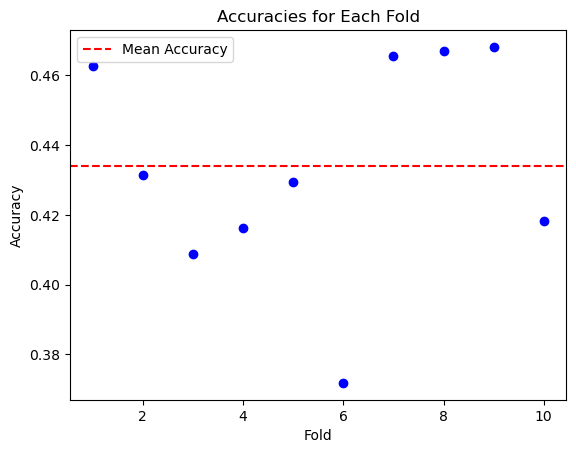

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
import random
from tensorflow.keras.layers import MaxPooling2D


# Função para criar o modelo
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3,3), strides=(1,1), activation='relu', input_shape=(n_mfcc, mfcc_time_size, 1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(32,(3,3), activation='relu',kernel_regularizer=l2(0.05)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.05)))
    model.add(Dropout(0.5))
    model.add(Dense(10,activation="softmax"))
    
    optimizer = Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Lista para armazenar as métricas de desempenho
accuracies = []

# Loop para cada fold
for fold_idx in range(10):
    
    # Escolher aleatoriamente um fold para validação
    validation_fold_idx = random.choice(range(10))
    while validation_fold_idx == fold_idx:
        validation_fold_idx = random.choice(range(10))
        
    # Substituir pelos nomes corretos das suas variáveis
    X_test = filtered_datasets_per_fold[fold_idx]
    y_test = filtered_Y_per_fold[fold_idx]['class_encoded']
    
    X_val= filtered_datasets_per_fold[validation_fold_idx]
    y_val = filtered_Y_per_fold[validation_fold_idx]['class_encoded']

    X_train = np.concatenate([filtered_datasets_per_fold[i] for i in range(10) if (i != fold_idx and i != validation_fold_idx)])
    y_train = pd.concat([filtered_Y_per_fold[i] for i in range(10) if (i != fold_idx and i != validation_fold_idx)])['class_encoded']

    # Calcular os pesos das classes
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

    # Normalizar os dados
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    X_val= np.array(X_val)

    # Encontrar o maior valor entre X_train e X_test
    max_value = max(X_train.max(), X_test.max())

    # Normalizar os dados
    X_train_scaled = X_train / max_value
    X_test_scaled = X_test / max_value
    X_val_scaled = X_val / max_value
    
    X_train_scaled=X_train_scaled.reshape(len(X_train_scaled),n_mfcc, mfcc_time_size, 1)
    X_test_scaled=X_test_scaled.reshape(len(X_test_scaled),n_mfcc, mfcc_time_size, 1)
    X_val_scaled=X_val_scaled.reshape(len(X_val_scaled),n_mfcc, mfcc_time_size, 1)
    
    input_shape=X_train_scaled[0].shape
    
    y_train_encoded = to_categorical(y_train,num_classes=10)
    y_test_encoded = to_categorical(y_test,num_classes=10)
    y_val_encoded = to_categorical(y_val,num_classes=10)
    
    
    # Criar e treinar o modelo
    model = create_model(input_shape, len(np.unique(y_train)))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001)

    
    # Treina o modelo
    history = model.fit(
        X_train_scaled,
        y_train_encoded,
        epochs=100, 
        batch_size=64,
        verbose=1,
        validation_data=(X_val_scaled, y_val_encoded),
        callbacks=[early_stopping]  
    )

    # Avaliar o modelo
    _, accuracy = model.evaluate(X_test_scaled, y_test_encoded)
    print(f"Accuracy for Fold {fold_idx + 1}: {accuracy}")
    accuracies.append(accuracy)
    plt.scatter(fold_idx + 1, accuracy, color='blue')

# Média e desvio padrão das acurácias
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"\nMean Accuracy: {mean_accuracy}")
print(f"Standard Deviation of Accuracy: {std_accuracy}")

# Adicionar uma linha para a média
plt.axhline(y=mean_accuracy, color='red', linestyle='--', label='Mean Accuracy')

# Adicionar rótulos e título ao gráfico
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracies for Each Fold')
plt.legend()

Epoch 1/100
109/109 [==============================] - 4s 30ms/step - loss: 3.3049 - accuracy: 0.1755 - val_loss: 2.2419 - val_accuracy: 0.1603
Epoch 2/100
109/109 [==============================] - 3s 32ms/step - loss: 2.1033 - accuracy: 0.2659 - val_loss: 2.0494 - val_accuracy: 0.2083
Epoch 3/100
109/109 [==============================] - 3s 30ms/step - loss: 1.9998 - accuracy: 0.3118 - val_loss: 1.9702 - val_accuracy: 0.3344
Epoch 4/100
109/109 [==============================] - 3s 30ms/step - loss: 1.9398 - accuracy: 0.3277 - val_loss: 1.9949 - val_accuracy: 0.3088
Epoch 5/100
109/109 [==============================] - 3s 29ms/step - loss: 1.9056 - accuracy: 0.3395 - val_loss: 1.9884 - val_accuracy: 0.2308
Epoch 6/100
109/109 [==============================] - 3s 29ms/step - loss: 1.8885 - accuracy: 0.3504 - val_loss: 1.9120 - val_accuracy: 0.3547
Epoch 7/100
109/109 [==============================] - 3s 29ms/step - loss: 1.8559 - accuracy: 0.3588 - val_loss: 1.8951 - val_accuracy:

109/109 [==============================] - 3s 28ms/step - loss: 1.6353 - accuracy: 0.4430 - val_loss: 1.6873 - val_accuracy: 0.3814
Epoch 58/100
109/109 [==============================] - 3s 29ms/step - loss: 1.6382 - accuracy: 0.4450 - val_loss: 1.7220 - val_accuracy: 0.3590
Epoch 59/100
109/109 [==============================] - 3s 29ms/step - loss: 1.6210 - accuracy: 0.4440 - val_loss: 1.7654 - val_accuracy: 0.3397
Epoch 60/100
109/109 [==============================] - 3s 28ms/step - loss: 1.6259 - accuracy: 0.4446 - val_loss: 1.6874 - val_accuracy: 0.3974
Epoch 61/100
26/26 [==============================] - 0s 3ms/step - loss: 1.5620 - accuracy: 0.5086

Best Model Accuracy: 0.5085784196853638
26/26 [==============================] - 0s 4ms/step


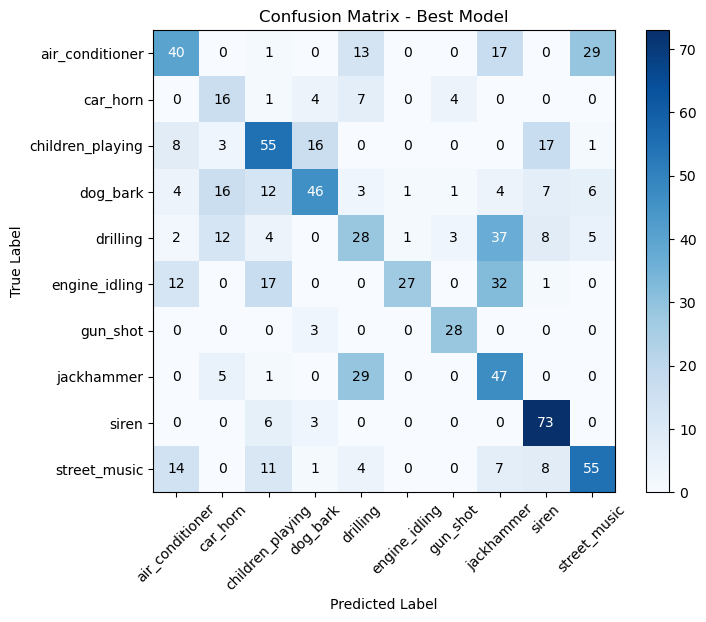

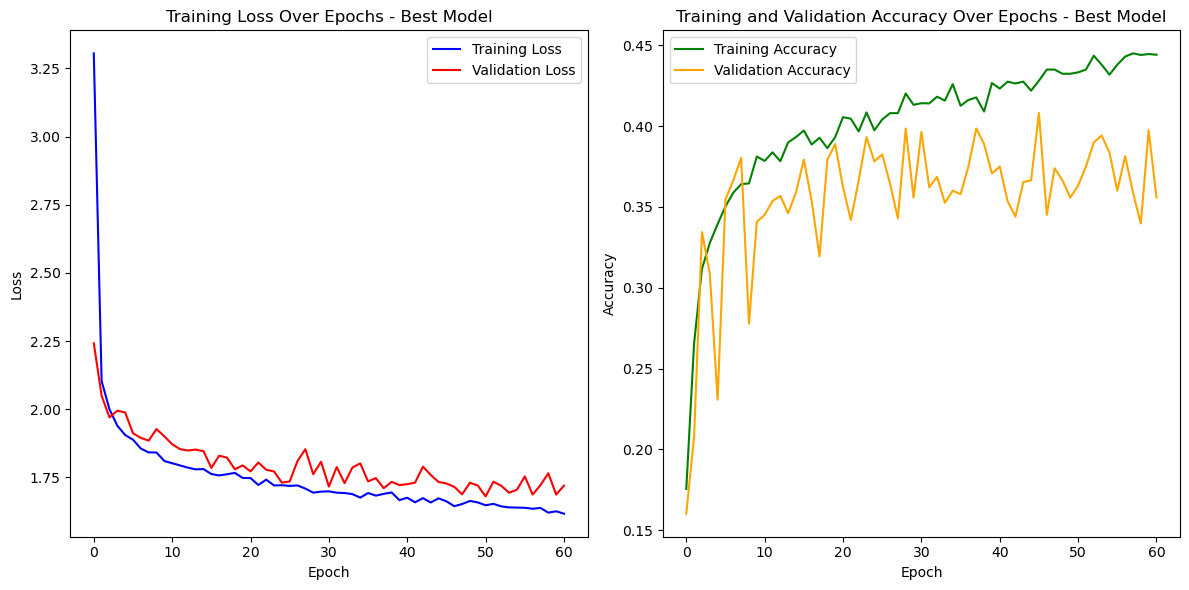

In [9]:
# Encontrar o índice do fold com a melhor acurácia
best_fold_idx = np.argmax(accuracies)

# Escolher aleatoriamente um fold para validação
best_validation_fold_idx = random.choice(range(10))
while best_validation_fold_idx == best_fold_idx:
    best_validation_fold_idx = random.choice(range(10))

# Substituir pelos nomes corretos das suas variáveis
X_test_best = filtered_datasets_per_fold[best_fold_idx]
y_test_best = filtered_Y_per_fold[best_fold_idx]['class_encoded']

X_val_best= filtered_datasets_per_fold[best_validation_fold_idx]
y_val_best = filtered_Y_per_fold[best_validation_fold_idx]['class_encoded']

X_train_best = np.concatenate([filtered_datasets_per_fold[i] for i in range(10) if (i != best_fold_idx and i != best_validation_fold_idx)])
y_train_best = pd.concat([filtered_Y_per_fold[i] for i in range(10) if (i != best_fold_idx and i != best_validation_fold_idx)])['class_encoded']

# Calcular os pesos das classes
class_weights_best = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_best), y=y_train_best)
class_weight_dict_best = dict(enumerate(class_weights_best))

# Normalizar os dados
#scaler_best = StandardScaler()
#X_train_scaled_best = scaler_best.fit_transform(X_train_best)
#X_test_scaled_best = scaler_best.transform(X_test_best)
X_train_scaled_best=X_train_best/max_value
X_test_scaled_best=X_test_best/max_value
X_val_scaled_best= X_val_best/max_value

X_train_scaled_best=X_train_scaled_best.reshape(len(X_train_scaled_best),n_mfcc, mfcc_time_size, 1)
X_test_scaled_best=X_test_scaled_best.reshape(len(X_test_scaled_best),n_mfcc, mfcc_time_size, 1)
X_val_scaled_best=X_val_scaled_best.reshape(len(X_val_scaled_best),n_mfcc, mfcc_time_size, 1)

y_train_encoded_best = to_categorical(y_train_best,num_classes=10)
y_test_encoded_best = to_categorical(y_test_best,num_classes=10)
y_val_encoded_best = to_categorical(y_val_best,num_classes=10)

input_shape = X_train_scaled_best[0].shape 

# Criar e treinar o modelo com todos os dados de treino
model_best = create_model(input_shape, len(np.unique(y_train_encoded_best)))

early_stopping_best = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001)

history_best = model_best.fit(
    X_train_scaled_best, 
    y_train_encoded_best, 
    validation_data=(X_val_scaled_best, y_val_encoded_best), 
    epochs=100, 
    batch_size=64, 
    class_weight=class_weight_dict_best,
    callbacks=[early_stopping_best]
)

# Avaliar o modelo com todos os dados de teste
_, accuracy_best = model_best.evaluate(X_test_scaled_best, y_test_encoded_best)
print(f"\nBest Model Accuracy: {accuracy_best}")

# Plotar a matriz de confusão do melhor modelo
y_pred_best = np.argmax(model_best.predict(X_test_scaled_best), axis=1)
conf_matrix_best = confusion_matrix(y_test_best, y_pred_best)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_best, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Model')
plt.colorbar()

classes_best = label_encoder.classes_
tick_marks_best = np.arange(len(classes_best))
plt.xticks(tick_marks_best, classes_best, rotation=45)
plt.yticks(tick_marks_best, classes_best)

# Exibir valores em cada elemento
for i in range(len(classes_best)):
    for j in range(len(classes_best)):
        plt.text(j, i, conf_matrix_best[i, j], ha="center", va="center", color="white" if conf_matrix_best[i, j] > conf_matrix_best.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotar treinamento e validação do melhor modelo - Loss e Accuracy
plt.figure(figsize=(12, 6))

# Plotar treinamento e validação da perda
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'], label='Training Loss', color='blue')
plt.plot(history_best.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training Loss Over Epochs - Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotar treinamento e validação da acurácia
plt.subplot(1, 2, 2)
plt.plot(history_best.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history_best.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs - Best Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
